Tom Do | Updated: 11/10/2022 6:00PM

# Intro

## README
When you download the Consulting Project folder, you can run all the blocks of codes below. You might not need to reset your working directtory. Remember to INSTALL necessary packages.

## Import these packages

In [26]:
import os
import pandas as pd
import numpy as np
import geopy.distance
import geopandas as gpd
from geopy import distance
import censusdata
from joblib import Parallel, delayed
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns


In [2]:
wd = os.getcwd()
print(wd)

/Users/tomvdo29/Desktop/Projects/Consulting Project


# Clean Data

## Clean and Merge TJX Client Data
Running this will export the cleaned Clients_Data.csv file

In [4]:
HG_TN = pd.read_csv(wd+"/Data/Client_Data/homegoods-tennessee.csv",skiprows=2)
HG_TN["State"] = "TN"
HG_FL = pd.read_csv(wd+"/Data/Client_Data/homegoods-florida.csv",skiprows=2)
HG_FL["State"] = "FL"
HG_AL = pd.read_csv(wd+"/Data/Client_Data/homegoods-alabama.csv",skiprows=2)
HG_AL["State"] = "AL"

TJM_TN = pd.read_csv(wd+"/Data/Client_Data/t-j-maxx-tennessee.csv",skiprows=2)
TJM_TN["State"] = "TN"
TJM_FL = pd.read_csv(wd+"/Data/Client_Data/t-j-maxx-florida.csv",skiprows=2)
TJM_FL["State"] = "FL"
TJM_AL = pd.read_csv(wd+"/Data/Client_Data/t-j-maxx-alabama.csv",skiprows=2)
TJM_AL["State"] = "AL"

MS_TN = pd.read_csv(wd+"/Data/Client_Data/marshalls-tennessee.csv",skiprows=2)
MS_TN["State"] = "TN"
MS_FL = pd.read_csv(wd+"/Data/Client_Data/marshalls-florida.csv",skiprows=2)
MS_FL["State"] = "FL"
MS_AL = pd.read_csv(wd+"/Data/Client_Data/marshalls-alabama.csv",skiprows=2)
MS_AL["State"] = "AL"

colnames = list(HG_TN.columns)

df = pd.DataFrame(columns=colnames)
for data in [HG_AL,HG_FL,HG_TN,TJM_AL,TJM_FL,TJM_TN,MS_AL,MS_FL,MS_TN]:
    #data = data.dropna().reset_index(drop=True)
    df = pd.concat([df,data], axis=0)
df = df.reset_index(drop=True)
df["Address"] = ""
for i in range(len(df.Name)):
    name_n_add = df["Name"][i].split(" / ").copy()
    df.loc[i,'Name'] = name_n_add[0]
    df.loc[i,'Address'] = name_n_add[1]

df = df.rename(columns={"lat": "Lat", "lng": "Long", "Total Visits":"Total_Visits"},errors="raise")
df[['Lat','Long']] = df[['Lat','Long']].astype(str)
df["client_coords"] = df["Lat"]+","+df["Long"]
df = df.rename(columns={'Store ID': 'Store_ID'})
df.to_csv(wd+"/Data/Final_Data/Clients_Data.csv",index=False)

## Clean and Merge Yardi Data

In [396]:
def clean_property_data(FL_property_file,Southern_property_file):

    FL_PropertyData = pd.read_csv(FL_property_file)
    Southern_PropertyData = pd.read_csv(Southern_property_file)

    PropertyData = pd.concat([FL_PropertyData,Southern_PropertyData],axis=0)

    col_names = list(PropertyData.columns)
    #print(col_names)
        
    # FL_Complete_Property = FL_PropertyData[FL_PropertyData.PROPERTY_STATUS=="Completed"]
    
    # print(FL_Complete_Property.PROPERTY_STUDENTHOUSING.unique())
    # print(FL_Complete_Property.PROPERTY_AFFORDABLEHOUSING.unique())
    # print(FL_Complete_Property.PROPERTY_MILITARYHOUSING.unique())
    # print(FL_Complete_Property.PROPERTY_AGERESTRICTED.unique())
    # print(FL_Complete_Property.PROPERTY_FRACTUREDCONDO.unique())
    # print(FL_Complete_Property.PROPERTY_ADAPTIVEREUSE.unique())
    # print(FL_Complete_Property.PROPERTY_SINGLEFAMILYRENTAL.unique())
    
    # print((FL_Complete_Property.PROPERTY_STUDENTHOUSING.isnull()).sum())
    
    df = PropertyData.loc[:, ['PROPERTY_ID', 'PROPERTY_NAME','PROPERTY_ADDRESS',
                              'PROPERTY_CITY', 'COUNTY_NAME', 'PROPERTY_STATE', 'PROPERTY_ZIPCODE',
                              'PROPERTY_LATITUDE', 'PROPERTY_LONGITUDE', 'PROPERTY_UNITS', 
                              'PROPERTY_SQFT', 'PROPERTY_IMPRATING', 'PROPERTY_LOCRATING', 
                              'PROPERTY_STATUS', 'PROPERTY_STUDENTHOUSING', 'PROPERTY_AFFORDABLEHOUSING', 
                              'PROPERTY_MILITARYHOUSING', 'PROPERTY_AGERESTRICTED', 'PROPERTY_FRACTUREDCONDO', 
                              'PROPERTY_ADAPTIVEREUSE', 'PROPERTY_SINGLEFAMILYRENTAL', 
                              'PROPERTY_CURRENT_OCCUPANCY', 'PROPERTY_CURRENT_RENT','PROPERTY_MIXEDUSE',
                              'PROPERTY_MIXEDUSE_NOTES']]
    
    df = df[df.PROPERTY_STATE.isin(["FL","AL","TN"])]
    df["PROPERTY_SQFT"] = np.where(df["PROPERTY_SQFT"]>0,df["PROPERTY_SQFT"],np.nan)

    df["Impr_Rating"] = np.where(df.PROPERTY_IMPRATING == "A+",9,
                        np.where(df.PROPERTY_IMPRATING == "A",8,
                        np.where(df.PROPERTY_IMPRATING == "A-",7,
                        np.where(df.PROPERTY_IMPRATING == "B+",6,
                        np.where(df.PROPERTY_IMPRATING == "B",5,
                        np.where(df.PROPERTY_IMPRATING == "B-",4,
                        np.where(df.PROPERTY_IMPRATING == "C+",3,
                        np.where(df.PROPERTY_IMPRATING == "C",2,
                        np.where(df.PROPERTY_IMPRATING == "C-",1,
                        np.where(df.PROPERTY_IMPRATING == "D",0,np.nan)))))))))).astype(float)
    
    df["Loc_Rating"] =  np.where(df.PROPERTY_LOCRATING == "A+",9,
                        np.where(df.PROPERTY_LOCRATING == "A",8,
                        np.where(df.PROPERTY_LOCRATING == "A-",7,
                        np.where(df.PROPERTY_LOCRATING == "B+",6,
                        np.where(df.PROPERTY_LOCRATING == "B",5,
                        np.where(df.PROPERTY_LOCRATING == "B-",4,
                        np.where(df.PROPERTY_LOCRATING == "C+",3,
                        np.where(df.PROPERTY_LOCRATING == "C",2,
                        np.where(df.PROPERTY_LOCRATING == "C-",1,
                        np.where(df.PROPERTY_LOCRATING == "D",0,np.nan))))))))))
    
    
    #df["Property_Overall_Rating"] = df[['Impr_Rating','Loc_Rating']].mean(axis=1,skipna = float)
    df["Property_Overall_Rating"] = df[['Impr_Rating','Loc_Rating']].max(axis=1,skipna = True)
    df["Property_Overall_Rating"] = np.where(df.Property_Overall_Rating >= 8, "Discretionary",
                                    np.where(df.Property_Overall_Rating >= 6, "High Mid-Range",
                                    np.where(df.Property_Overall_Rating >= 4, "Low Mid-Range",
                                    np.where(df.Property_Overall_Rating >= 0, "Workforce", ""))))
    
    df["Impr_Rating"] = np.where(df.Impr_Rating >= 8, "Discretionary",
                        np.where(df.Impr_Rating >= 6, "High Mid-Range",
                        np.where(df.Impr_Rating >= 4, "Low Mid-Range",
                        np.where(df.Impr_Rating >= 0, "Workforce", ""))))
    df["Loc_Rating"] =  np.where(df.Loc_Rating >= 8, "Discretionary",
                        np.where(df.Loc_Rating >= 6, "High Mid-Range",
                        np.where(df.Loc_Rating >= 4, "Low Mid-Range",
                        np.where(df.Loc_Rating >= 0, "Workforce", ""))))
    df["Unit_size"] = df.PROPERTY_SQFT/df.PROPERTY_UNITS # Estimate unit size
    
    df["Student_Housing"] = np.where(df.PROPERTY_STUDENTHOUSING == "N", 0,
                            np.where(df.PROPERTY_STUDENTHOUSING.isin(["A","P"]), 1, np.nan))
    
    df["Affordable_Housing"] = np.where(df.PROPERTY_AFFORDABLEHOUSING == "N", 0,
                            np.where(df.PROPERTY_AFFORDABLEHOUSING.isin(["A","P"]), 1, np.nan))
    
    df["Military_Housing"] = np.where(df.PROPERTY_MILITARYHOUSING == "N", 0,
                            np.where(df.PROPERTY_MILITARYHOUSING.isin(["A","P"]), 1, np.nan))
    
    df["Senior_Housing"] = np.where(df.PROPERTY_AGERESTRICTED == "N", 0,
                            np.where(df.PROPERTY_AGERESTRICTED.isin(["A","P"]), 1, np.nan))
    
    df["Fractured_Condo"] = np.where(df.PROPERTY_FRACTUREDCONDO == "N", 0,
                            np.where(df.PROPERTY_FRACTUREDCONDO.isin(["A","P"]), 1, np.nan))
    
    df["Adaptive_Reuse"] = np.where(df.PROPERTY_ADAPTIVEREUSE == True, 1,
                            np.where(df.PROPERTY_ADAPTIVEREUSE == False, 0, np.nan))
    
    df["Single_Family_Rental"] = np.where(df.PROPERTY_SINGLEFAMILYRENTAL == True, 1,
                            np.where(df.PROPERTY_SINGLEFAMILYRENTAL == False, 0, np.nan))
    
    df["Mixed_Use"] = np.where(df.PROPERTY_MIXEDUSE == True, 1,
                            np.where(df.PROPERTY_MIXEDUSE == False, 0, np.nan))
    
    sqft_mixed_use = []
    for note in df['PROPERTY_MIXEDUSE_NOTES']:
        if type(note) == str:
            numbers = np.array([float(num) for num in note.replace(",","").split(" ") if num.isdigit()])
            sqft_mixed_use.append(sum(numbers))
        else:
            sqft_mixed_use.append(0)
    
    sqft_mixed_use = np.array(sqft_mixed_use)
    
    df["sqft_mixed_use"] = sqft_mixed_use
    
    # Manual Fill Missing Data :(
    df.loc[5239,"PROPERTY_LATITUDE"] = "27.379895"
    df.loc[5239,"PROPERTY_LONGITUDE"] = "-82.541608"
    
    df[['PROPERTY_LATITUDE','PROPERTY_LONGITUDE']] = df[['PROPERTY_LATITUDE','PROPERTY_LONGITUDE']].astype(str)
    df["property_coords"] = df["PROPERTY_LATITUDE"]+","+df["PROPERTY_LONGITUDE"]
    return df

FL_property_file = wd+"/Data/FL_Property_Data/FloridaPropertyData.csv"
Southern_property_file = wd+"/Data/South_Property_Data/SouthPropertyData.csv"
all_property_data = clean_property_data(FL_property_file,Southern_property_file)
all_property_data.to_csv(wd+"/Data/Final_Data/Properties_Data_3States.csv")

In [397]:
FL_RentAndOccupancyData_files = [wd+"/Data/FL_Property_Data/RentAndOccupancyData{}.csv".format(i) for i in range(1,6)]
South_RentAndOccupancyData_files = [wd+"/Data/South_Property_Data/RentAndOccupancyData{}.csv".format(i) for i in range(1,5)]
RentAndOccupancyData_files = FL_RentAndOccupancyData_files+South_RentAndOccupancyData_files


In [398]:
pd.read_csv(wd+"/Data/FL_Property_Data/RentAndOccupancyData{}.csv".format(2)).columns

Index(['PROPERTY_ID', 'MARKET_NAME', 'SUBMARKET_NAME', 'PROPERTY_NAME',
       'SERIES', '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
       '2002-05-01',
       ...
       '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
       '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01'],
      dtype='object', length=251)

In [399]:
dfs = []

from datetime import datetime
# Iterate over file paths and read each CSV into a DataFrame
for file_path in RentAndOccupancyData_files:
    df = pd.read_csv(file_path)
    col_names = df.columns
    for name in col_names:
        if "/" in name:
            df = df.rename(columns = {name:datetime.strptime(name, "%m/%d/%y").strftime("%Y-%m-%d")})
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
concatenated_df = pd.concat(dfs, ignore_index=False, axis=0)
concatenated_df.SERIES = [string.replace(" ", "_") for string in concatenated_df.SERIES]
# Display the concatenated DataFrame
concatenated_df.columns

Index(['PROPERTY_ID', 'MARKET_NAME', 'SUBMARKET_NAME', 'PROPERTY_NAME',
       'SERIES', '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
       '2002-05-01',
       ...
       '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
       '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01'],
      dtype='object', length=251)

In [400]:
property_ids = np.unique(concatenated_df.PROPERTY_ID)
metrics = np.unique(concatenated_df.SERIES)
time_colummns = concatenated_df.columns[5:]

In [401]:
renting_df = pd.DataFrame(index=range(len(property_ids)))
i = 0
for prop_id in property_ids:
    if i == 0:
        renting_df.insert(loc=0, column='PROPERTY_ID', value=np.nan) # Init
    renting_df.loc[i, 'PROPERTY_ID'] = prop_id
    temp = concatenated_df[concatenated_df.PROPERTY_ID == prop_id]
    current_year = int(time_colummns[-1][0:4])
    for timeframe in [1,2,3,5]:
        years_to_cover = list(range(current_year-timeframe,current_year+1))
        time_cols = [date for date in time_colummns if int(date[0:4]) in years_to_cover]
        select_cols = ['SERIES'] + time_cols
        temp1 = temp[select_cols]
        melted_df = pd.melt(temp1, id_vars=['SERIES'], var_name='Date', value_name='Value').pivot(index='Date', columns='SERIES')

        melted_df.columns = melted_df.columns.droplevel()
        melted_df.reset_index(inplace=True)
        melted_df['Year'] = pd.to_datetime(melted_df['Date']).dt.year
        mean_by_year = melted_df.groupby('Year')[metrics].mean()
        change_data = mean_by_year.pct_change(periods=timeframe).dropna(how='all')
        change_data.Occupancy_Rate = mean_by_year.diff(periods=timeframe).dropna().Occupancy_Rate
        change_data = change_data.reset_index(drop=True)
        if len(change_data) > 0:
            # Initiate new columns
            changes_metrics = ["%_change_in_"+metric+"_{}_year".format(timeframe) for metric in metrics]
            for new_column in changes_metrics:
                if i == 0:
                    renting_df.insert(loc=1, column=new_column, value=np.nan)

                for metric in metrics:
                    if metric in new_column:
                        renting_df.loc[i,new_column] = change_data[metric][0]
    for metric in metrics:
        current_metric = "current_"+metric
        if i == 0:
            renting_df.insert(loc=1, column=current_metric, value=np.nan)
        renting_df.loc[i,current_metric] = mean_by_year.loc[2022,metric]
        
    i+=1


In [402]:
merged_df = pd.merge(all_property_data, renting_df, on='PROPERTY_ID')
merged_df.tail()

,PROPERTY_ID,PROPERTY_NAME,PROPERTY_ADDRESS,PROPERTY_CITY,COUNTY_NAME,PROPERTY_STATE,PROPERTY_ZIPCODE,PROPERTY_LATITUDE,PROPERTY_LONGITUDE,PROPERTY_UNITS,PROPERTY_SQFT,PROPERTY_IMPRATING,PROPERTY_LOCRATING,PROPERTY_STATUS,PROPERTY_STUDENTHOUSING,PROPERTY_AFFORDABLEHOUSING,PROPERTY_MILITARYHOUSING,PROPERTY_AGERESTRICTED,PROPERTY_FRACTUREDCONDO,PROPERTY_ADAPTIVEREUSE,PROPERTY_SINGLEFAMILYRENTAL,PROPERTY_CURRENT_OCCUPANCY,PROPERTY_CURRENT_RENT,PROPERTY_MIXEDUSE,PROPERTY_MIXEDUSE_NOTES,Impr_Rating,Loc_Rating,Property_Overall_Rating,Unit_size,Student_Housing,Affordable_Housing,Military_Housing,Senior_Housing,Fractured_Condo,Adaptive_Reuse,Single_Family_Rental,Mixed_Use,sqft_mixed_use,property_coords,current_Rent_Per_SqFt_Market,current_Rent_Per_SqFt_Actual,current_Rent_Market,current_Rent_Actual,current_Occupancy_Rate,%_change_in_Rent_Per_SqFt_Market_5_year,%_change_in_Rent_Per_SqFt_Actual_5_year,%_change_in_Rent_Market_5_year,%_change_in_Rent_Actual_5_year,%_change_in_Occupancy_Rate_5_year,%_change_in_Rent_Per_SqFt_Market_3_year,%_change_in_Rent_Per_SqFt_Actual_3_year,%_change_in_Rent_Market_3_year,%_change_in_Rent_Actual_3_year,%_change_in_Occupancy_Rate_3_year,%_change_in_Rent_Per_SqFt_Market_2_year,%_change_in_Rent_Per_SqFt_Actual_2_year,%_change_in_Rent_Market_2_year,%_change_in_Rent_Actual_2_year,%_change_in_Occupancy_Rate_2_year,%_change_in_Rent_Per_SqFt_Market_1_year,%_change_in_Rent_Per_SqFt_Actual_1_year,%_change_in_Rent_Market_1_year,%_change_in_Rent_Actual_1_year,%_change_in_Occupancy_Rate_1_year
6094,143_424,Executive Lodge,1535 Sparkman Drive NW,Huntsville,Madison,AL,35816.0,34.741245,-86.64714,308,200080.0,B-,B-,Completed,N,N,N,N,NaN,NaN,NaN,98.1,686.0,False,NaN,Low Mid-Range,Low Mid-Range,Low Mid-Range,649.610390,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,"34.741245,-86.64714",1.142,1.102,742.6,716.6,98.625,0.113241,0.108466,0.113761,0.108573,0.683333,0.042129,0.042902,0.042733,0.043719,1.591667,0.126048,0.114069,0.126432,0.114608,1.058333,0.040547,0.039623,0.042246,0.041570,0.525
6095,143_473367,"Moderne at Providence, The",30 Gates Mill Street NW,Huntsville,Madison,AL,35806.0,34.753764,-86.697246,300,299370.0,A-,B,Completed,N,N,N,N,NaN,NaN,NaN,96.3,1430.0,False,NaN,High Mid-Range,Low Mid-Range,High Mid-Range,997.900000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,"34.753764,-86.697246",1.490,1.494,1488.0,1490.4,97.000,NaN,NaN,NaN,NaN,NaN,0.236515,0.231319,0.236394,0.230380,-0.675000,0.126654,0.128257,0.127842,0.127241,-0.583333,0.064920,0.065874,0.065903,0.065459,-0.275
6096,143_932053,Colonial Grand at Madison,2300 Colonial Lake Drive,Madison,Madison,AL,35758.0,34.688868,-86.732076,336,354592.0,B+,B-,Completed,N,N,N,N,NaN,NaN,NaN,95.2,1407.0,False,NaN,High Mid-Range,Low Mid-Range,High Mid-Range,1055.333333,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,"34.688868,-86.732076",1.280,1.274,1349.8,1344.8,95.350,NaN,NaN,NaN,NaN,NaN,0.238710,0.236893,0.236458,0.237546,-2.550000,0.218081,0.217197,0.216767,0.217473,-2.525000,0.047749,0.046407,0.046898,0.046673,-0.675
6097,190_1152206,Evergreen Terrace,902 Ashley Road,Johnson City,Washington,TN,37604.0,36.2993499,-82.384005,358,NaN,C+,C+,Completed,N,N,N,N,NaN,NaN,NaN,NaN,NaN,False,NaN,Workforce,Workforce,Workforce,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,"36.2993499,-82.384005",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6098,190_1152213,"Haven at Knob Creek, The",1185 West Mountain View Road,Johnson City,Washington,TN,37604.0,36.343916,-82.4132683,372,381666.0,B+,B+,Completed,N,N,N,N,NaN,NaN,NaN,NaN,1066.0,False,NaN,High Mid-Range,High Mid-Range,High Mid-Range,1025.983871,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,"36.343916,-82.4132683",1.132,1.128,1162.6,1158.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.088462,0.084615,0.086542,0.086867,NaN


In [403]:
merged_df.to_csv(wd+"/Data/Final_Data/Properties_Renting_3States.csv")

## Clean and Merge Grocery Data T2

In [8]:
T12_AL = pd.read_excel(wd+"/Data/T12_Grocery_Visits/T12 AL Grocery.xlsx",skiprows=1)
T12_AL["State"] = "AL"
T12_FL = pd.read_excel(wd+"/Data/T12_Grocery_Visits/T12 FL Grocery.xlsx",skiprows=1)
T12_FL["State"] = "FL"
T12_TN = pd.read_excel(wd+"/Data/T12_Grocery_Visits/T12 TN Grocery.xlsx",skiprows=1)
T12_TN["State"] = "TN"

df = pd.concat([T12_AL,T12_FL,T12_TN], axis=0).reset_index(drop=True)

for i in range(len(df.Name)):
    name_n_add = df["Name"][i].split(" / ").copy()
    df.loc[i,'Name'] = name_n_add[0]
    df.loc[i,'Address'] = name_n_add[1]
df = df.rename(columns={"lat": "Lat", "lng": "Long", "Total Visits":"Total_Visits"},errors="raise")
df[['Lat','Long']] = df[['Lat','Long']].astype(str)
df["grocery_coords"] = df["Lat"]+","+df["Long"]
df.to_csv(wd+"/Data/Final_Data/T12Data.csv",index=False)

## Merge Starbucks Data

In [10]:
Starbuck_FL = pd.read_csv(wd+"/Data/Starbucks_Data/Starbucks_FL.csv")
Starbuck_TN = pd.read_csv(wd+"/Data/Starbucks_Data/Starbucks_TN.csv")
Starbuck_AL = pd.read_csv(wd+"/Data/Starbucks_Data/Starbucks_AL.csv")

Starbucks_df = pd.concat([Starbuck_AL,Starbuck_FL,Starbuck_TN],ignore_index=True)
Starbucks_df[['Latitude','Longitude']] = Starbucks_df[['Latitude','Longitude']].astype(str)
Starbucks_df["starbucks_coords"] = Starbucks_df["Latitude"]+","+Starbucks_df["Longitude"]
Starbucks_df.to_csv(wd+"/Data/Final_Data/Starbucks_Data.csv", index = False)

## Clean and Merge Competitors Data

In [9]:
burlingtonAL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - burlington-alabama (Total).csv",skiprows=2)
burlingtonAL_df['State'] = "AL"
burlingtonFL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - burlington-florida (Total).csv",skiprows=2)
burlingtonFL_df['State'] = "FL"
burlingtonTN_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - burlington-tennessee (Total).csv",skiprows=2)
burlingtonTN_df['State'] = "TN"

KohlsAL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - kohl-s-alabama (Total).csv",skiprows=2,index_col=None)
KohlsFL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - kohl-s-florida (Total).csv",skiprows=2,index_col=None)
KohlsTN_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - kohl-s-tennessee (Total).csv",skiprows=2,index_col=None)
KohlsAL_df['State'] = "AL"
KohlsFL_df['State'] = "FL"
KohlsTN_df['State'] = "TN"

lowesAL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - lowe-s-alabama (Total).csv",skiprows=2,index_col=None)
lowesFL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - lowe-s-florida (Total).csv",skiprows=2,index_col=None)
lowesTN_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - lowe-s-tennessee (Total).csv",skiprows=2,index_col=None)
lowesAL_df['State'] = "AL"
lowesFL_df['State'] = "FL"
lowesTN_df['State'] = "TN"

rossAL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - ross-dress-for-less-alabama (Total).csv",skiprows=2,index_col=None)
rossFL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - ross-dress-for-less-florida (Total).csv",skiprows=2,index_col=None)
rossTN_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - ross-dress-for-less-tennessee (Total).csv",skiprows=2,index_col=None)
rossAL_df['State'] = "AL"
rossFL_df['State'] = "FL"
rossTN_df['State'] = "TN"

HomeDepotAL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - the-home-depot-alabama (Total).csv",skiprows=2,index_col=None)
HomeDepotFL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - the-home-depot-florida (Total).csv",skiprows=2,index_col=None)
HomeDepotTN_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - the-home-depot-tennessee (Total).csv",skiprows=2,index_col=None)
HomeDepotAL_df['State'] = "AL"
HomeDepotFL_df['State'] = "FL"
HomeDepotTN_df['State'] = "TN"

WalmartAL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - walmart-alabama (Total).csv",skiprows=2,index_col=None)
WalmartFL_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - walmart-florida (Total).csv",skiprows=2,index_col=None)
WalmartTN_df = pd.read_csv(wd+"/Data/Competing_stores/Ranked Venues - walmart-tennessee (Total).csv",skiprows=2,index_col=None)
WalmartAL_df['State'] = "AL"
WalmartFL_df['State'] = "FL"
WalmartTN_df['State'] = "TN"

competitors_df = pd.concat([burlingtonAL_df,burlingtonFL_df,burlingtonTN_df,
                            KohlsAL_df,KohlsFL_df,KohlsTN_df,
                            lowesAL_df,lowesFL_df,lowesTN_df,
                            rossAL_df,rossFL_df,rossTN_df,
                            HomeDepotAL_df,HomeDepotFL_df,HomeDepotTN_df,
                            WalmartAL_df,WalmartFL_df,WalmartTN_df],ignore_index=True)

competitors_df[['lat','lng']] = competitors_df[['lat','lng']].astype(str)
competitors_df["competitor_coords"] = competitors_df["lat"]+","+competitors_df["lng"]
competitors_df['Comp_Name'] = ""
competitors_df['Comp_Address'] = ""


for i in range(len(competitors_df.Name)):
    name_n_add = competitors_df["Name"][i].split(" / ")
    competitors_df.loc[i,'Comp_Name'] = name_n_add[0]
    competitors_df.loc[i,'Comp_Address'] = name_n_add[1]
competitors_df = competitors_df.rename(columns={"Total Visits":"Total_Visits"},errors="raise")
competitors_df = competitors_df.drop(columns = "Name")
competitors_df.to_csv(wd+"/Data/Final_Data/competing_data.csv",index=False)

## Clean and Merge Malls Data

In [10]:
AL_mall = pd.read_excel(wd+"/Data/Malls_Data/AlabamaMalls.xlsx")
TN_mall = pd.read_excel(wd+"/Data/Malls_Data/TenesseMalls.xlsx")
FL_mall = pd.read_excel(wd+"/Data/Malls_Data/FloridaMalls.xlsx")

mall_data = pd.concat([AL_mall,TN_mall,FL_mall],ignore_index=True)

mall_data["State"] = np.where(mall_data["State"] == "Florida", "FL",
                              np.where(mall_data["State"] == "Tennessee", "TN",
                              np.where(mall_data["State"] == "Alabama", "AL","")))

mall_data["Total_Stores"] = mall_data["Total_Stores"].str.extract('(\d+)').astype(float)
mall_data[['Latitude','Longitude']] = mall_data[['Latitude','Longitude']].astype(str)
mall_data["mall_coords"] = mall_data["Latitude"]+","+mall_data["Longitude"]

mall_data = mall_data[["Mallname","City","State","mall_coords","Total_Stores"]]
mall_data = mall_data.fillna(0)

mall_data.to_csv(wd+"/Data/Final_Data/Malls_Data.csv", index=False)

## Pull Census Data In All Census Tracts of 3 States

In [246]:
AL_tract = gpd.read_file(wd+"/Data/All_Tracts/AL_Tract/tl_2022_01_tract.shp")
FL_tract = gpd.read_file(wd+"/Data/All_Tracts/FL_Tract/tl_2022_12_tract.shp")
TN_tract = gpd.read_file(wd+"/Data/All_Tracts/TN_Tract/tl_2022_47_tract.shp")

All_States_Tract = gpd.GeoDataFrame(pd.concat([AL_tract, FL_tract, TN_tract])).reset_index(drop=True)
All_States_Tract = pd.DataFrame(All_States_Tract.drop(columns='geometry'))

All_States_Tract['Household_Income_0-25K'] = np.nan
All_States_Tract['Household_Income_25K-50K'] = np.nan
All_States_Tract['Household_Income_50K-75K'] = np.nan
All_States_Tract['Household_Income_75K-100K'] = np.nan
All_States_Tract['Household_Income_100K-150K'] = np.nan
All_States_Tract['Household_Income_150K+'] = np.nan


def censustract(i):
    tract_pop_array = []
    tract_med_income = [] 
    state = str(All_States_Tract['STATEFP'][i])
    tract = str(All_States_Tract['TRACTCE'][i])
    county = str(All_States_Tract['COUNTYFP'][i])
    
    
    AcsData = censusdata.download('acs5', 2020, censusdata.censusgeo([('state',state),
                                                                      ('county',county), 
                                                                      ('tract',tract)]), 
                                  ['B19101_002E','B19101_003E','B19101_004E','B19101_005E','B19101_006E',
                                   'B19101_007E','B19101_008E','B19101_009E','B19101_010E','B19101_011E',
                                   'B19101_012E','B19101_013E','B19101_014E','B19101_015E','B19101_016E',"B19101_017E"],
                                  key = "456cc172706c0e88d800aa401a0daef16a303b00").values
    
    return AcsData[0,0]+AcsData[0,1]+AcsData[0,2]+AcsData[0,3],AcsData[0,4]+AcsData[0,5]+\
           AcsData[0,6]+AcsData[0,7]+AcsData[0,8],AcsData[0,9]+AcsData[0,10],AcsData[0,11],\
           AcsData[0,12]+AcsData[0,13],AcsData[0,14]+AcsData[0,15]
    #tract_med_income.append(AcsData[0,1])
    
    
results = Parallel(n_jobs=20)(delayed(censustract)(i) for i in range(0,len(All_States_Tract)))

for i in range(len(results)):
    All_States_Tract.loc[i,'Household_Income_0-25K'] = results[i][0]
    All_States_Tract.loc[i,'Household_Income_25K-50K'] = results[i][1]
    All_States_Tract.loc[i,'Household_Income_50K-75K'] = results[i][2]
    All_States_Tract.loc[i,'Household_Income_75K-100K'] = results[i][3]
    All_States_Tract.loc[i,'Household_Income_100K-150K'] = results[i][4]
    All_States_Tract.loc[i,'Household_Income_150K+'] = results[i][5]
    
All_States_Tract[['INTPTLAT','INTPTLON']] = All_States_Tract[['INTPTLAT','INTPTLON']].astype(str)
All_States_Tract["tract_coords"] = All_States_Tract["INTPTLAT"]+","+All_States_Tract["INTPTLON"]
    
All_States_Tract.to_csv(wd+"/Data/Final_Data/Census_Data.csv", index=False)

# Variables Creation

## T12 Grocery Data Analysis

In [248]:
def nearby_supermarkets_analysis(i,client_file,grocery_file,states,radius):
    clientDF = pd.read_csv(client_file)
    clientDF = clientDF[["Rank","Name","State","client_coords","Total_Visits"]]

    # Read grocery_file and filter state
    groceryDF = pd.read_csv(grocery_file)
    groceryDF = groceryDF[groceryDF.State.isin(states)].reset_index(drop=True)
    
    
    # See what grocery stores are there in the data
    
    # Establish new variable name: "name num_stores_" + name of grocery store
    # to count how many of that grocery brand within the client radius
    global numstore_col_names
    numstore_col_names = ("num_stores_"+groceryDF.Name.unique())
    numstore_col_names = [name.replace(' ','_') for name in numstore_col_names]
    
    # Establish new variable name: "store_visit_" + name of grocery store
    # to store total visit of that grocery brand within the client radius
    global storevisit_col_names
    storevisit_col_names = ("total_visit_"+groceryDF.Name.unique())
    storevisit_col_names = [name.replace(' ','_') for name in storevisit_col_names]


    numstore_list = [] # To keep track the total number of all grocery stores
    total_visit = [] # To keep track the total visit of all grocery stores
    
    # Put new variables name into a dataframe format
    df_num_store = pd.DataFrame(columns=numstore_col_names)
    df_store_visits = pd.DataFrame(columns=storevisit_col_names)
    
    # Loop through every client store
    num_stores = 0 # Total number of grocery stores sets at 0
    visits = np.nan # Total visit to all grocery stores sets at 0
    # Create dataframe to count whether number of grocery stores and append
    # the number of visit of that store if it is within the client radius
    df_num_store_running = pd.DataFrame(columns=numstore_col_names)
    df_store_visits_running = pd.DataFrame(columns=storevisit_col_names)

    for b in range(len(groceryDF["grocery_coords"])):
        #geopy.distance.geodesic(clientDF["client_coords"][a], groceryDF["grocery_coords"][b]).miles
        dis = geopy.distance.geodesic(clientDF.loc[i,"client_coords"], groceryDF.loc[b,"grocery_coords"]).miles


        if dis <= radius: # Set radius equal 3 miles
            # Set 1 if the store is within the client radius or 0 otherwise
            # then append to the df_num_store_running
      
            index_numstore = list(numstore_col_names).index(("num_stores_"+groceryDF.Name[b]).replace(' ','_'))
            lst_numstore = [0]*len(numstore_col_names)
            lst_numstore[index_numstore] = 1
            num_store_dic = dict(zip(numstore_col_names,lst_numstore))
            df_num_store_running = pd.concat([df_num_store_running,pd.DataFrame(num_store_dic,index=[0])],ignore_index=True)

            # Update the grocery store visit if the grocery store is within
            # the client radius and NULL otherwise
            index_storevisits = list(storevisit_col_names).index(("total_visit_"+groceryDF.Name[b]).replace(' ','_'))
            lst_storevisits = [np.nan]*len(storevisit_col_names)
            lst_storevisits[index_storevisits] = groceryDF.Total_Visits[b]
            store_visit_dic = dict(zip(storevisit_col_names,lst_storevisits))
            df_store_visits_running= pd.concat([df_store_visits_running,pd.DataFrame(store_visit_dic,index=[0])],ignore_index=True)
            
            # Update the number of grocery store when it's within the client radius
            num_stores+=1
            
            # Update the number of grocery store visit if the store is within the client radius

            if np.isnan(visits):
                visits = groceryDF["Total_Visits"][b]
            else:
                visits += groceryDF["Total_Visits"][b]
        
    # Append to the list 
    numstore_list.append(num_stores)
    total_visit.append(visits)
    
    # Find the total number and the total visit of each grocery brand and append
    # to the keep-trach dataframe
    df_num_store = df_num_store.append(df_num_store_running[numstore_col_names].sum(),ignore_index=True)
    df_store_visits = df_store_visits.append(df_store_visits_running[storevisit_col_names].sum(min_count=1),ignore_index=True)
    #print(df_num_store)
    #print(df_result)
    

    return (num_stores,visits,df_num_store,df_store_visits)

def supermarket_parallel_processing(client_file,grocery_file,states,radius):
    clientDF = pd.read_csv(client_file)
    clientDF = clientDF[["Rank","Name","State","client_coords","Total_Visits"]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    
    results = Parallel(n_jobs=20)(delayed(nearby_supermarkets_analysis)(i,client_file,grocery_file,states,radius) for i in range(clientDF.shape[0]))
    # Merge all the keeping-trach result to the output dataframe 
    numstore_list = [] # To keep track the total number of all grocery stores
    total_visit = [] # To keep track the total visit of all grocery stores
    nearby_supermarkets_analysis(0,client_file,grocery_file,states,radius) 
    df_num_store = pd.DataFrame(columns=numstore_col_names)
    df_store_visits = pd.DataFrame(columns=storevisit_col_names)
    
    for row in results:
        numstore_list.append(row[0])
        total_visit.append(row[1])
        df_num_store = df_num_store.append(row[2], ignore_index = True)
        df_store_visits = df_store_visits.append(row[3], ignore_index = True)
    clientDF = pd.concat([clientDF,df_num_store],axis = 1)
    clientDF = pd.concat([clientDF,df_store_visits],axis = 1)
    clientDF["num_grocery_stores"] = np.array(numstore_list)
    clientDF["total_grocery_visit"] = np.array(total_visit)
    return clientDF

## Yardi Data Analysis

In [247]:
def nearby_properties_analysis(i,client_file,real_estate,states,radius):
    
    # Read client_file and filter state
    clientDF = pd.read_csv(client_file)
    clientDF = clientDF.loc[[i],["Rank","Name","State","client_coords","Total_Visits"]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)

    # Read Yardi data and filter out states
    propertyDF = pd.read_csv(real_estate)
    propertyDF = propertyDF[propertyDF.PROPERTY_STATE.isin(states)].reset_index()
    # propertyDF = propertyDF[propertyDF.PROPERTY_STATUS == "Completed"].reset_index() # Filter out completed properties
    propertyDF["Unit_size"] = propertyDF.PROPERTY_SQFT/propertyDF.PROPERTY_UNITS # Estimate unit size
    
    # Make dictionaries to store results of number of properties, 
    # average sqft, and average rent by type of apartments
    numsproperty_dict = {"Discretionary":[], "High-Mid-Range":[],"Low-Mid-Range":[], "Workforce":[]}
    property_sqft = {"Discretionary":[], "High-Mid-Range":[],"Low-Mid-Range":[], "Workforce":[]}
    property_rent = {"Discretionary":[], "High-Mid-Range":[],"Low-Mid-Range":[], "Workforce":[]}
    
    # Make dataframe to store results of number of apartments by type of housing 
    # categories
    type_rent_dict = {"Student_Housing":[], "Affordable_Housing":[],"Military_Housing":[], 
                 "Senior_Housing":[], "Adaptive_Reuse":[], "Single_Family_Rental":[]}
    type_rent = pd.DataFrame.from_dict(type_rent_dict)
    
    property_status_dict = {"Completed":[], "Planned":[],"Prospective":[], "Under_Construction":[]}
    property_status = pd.DataFrame.from_dict(property_status_dict)

        # Make dictionaries and dataframe to keep track of properties that 
        # are within the the client store radius 
    num_prop_status = {"Completed":0, "Planned":0,"Prospective":0, "Under_Construction":0}
    num_prop = {"Discretionary":0, "High-Mid-Range":0,"Low-Mid-Range":0, "Workforce":0}
    running_sqft = {"Discretionary":[], "High-Mid-Range":[],"Low-Mid-Range":[], "Workforce":[]}
    running_rent = {"Discretionary":[], "High-Mid-Range":[],"Low-Mid-Range":[], "Workforce":[]}
    type_rent_df = pd.DataFrame(columns=type_rent_dict.keys())
    
    current_state = clientDF['State'][0]
    current_state_props = propertyDF[propertyDF.PROPERTY_STATE == current_state].reset_index(drop=True)
    
    distance_list = []
    # Loop through every property
    for b in range(len(current_state_props["property_coords"])):
        dis = geopy.distance.geodesic(clientDF["client_coords"][0], current_state_props["property_coords"][b]).miles
        distance_list.append(dis)
        if dis <= radius: # Set radius
            
            # Update 1 to each type of rent if the property satisfies conditions
            # to each type of rent: StudentHousing,...
            type_rent_df = type_rent_df.append(current_state_props.loc[b,'Student_Housing':'Single_Family_Rental'],ignore_index=True)
        
            if type(current_state_props["PROPERTY_STATUS"][b]) == str:
                num_prop_status[current_state_props["PROPERTY_STATUS"][b].replace(" ","_")] += 1
            
            # Update number of properies and append the sqft and rent amount
            # according to its overall ratings if the property if within the radius 
            if "Discretionary" in [current_state_props.Impr_Rating[b],current_state_props.Loc_Rating[b]]:
                num_prop["Discretionary"] += 1
                running_sqft["Discretionary"].append(current_state_props["Unit_size"][b])
                running_rent["Discretionary"].append(current_state_props["PROPERTY_CURRENT_RENT"][b])
                
            elif "High Mid-Range" in [current_state_props.Impr_Rating[b],current_state_props.Loc_Rating[b]]:
                num_prop["High-Mid-Range"] += 1
                running_sqft["High-Mid-Range"].append(current_state_props["Unit_size"][b])
                running_rent["High-Mid-Range"].append(current_state_props["PROPERTY_CURRENT_RENT"][b])
                
            elif "Low Mid-Range" in [current_state_props.Impr_Rating[b],current_state_props.Loc_Rating[b]]:
                num_prop["Low-Mid-Range"] += 1
                running_sqft["Low-Mid-Range"].append(current_state_props["Unit_size"][b])
                running_rent["Low-Mid-Range"].append(current_state_props["PROPERTY_CURRENT_RENT"][b])
                
            elif "Workforce" in [current_state_props.Impr_Rating[b],current_state_props.Loc_Rating[b]]:
                num_prop["Workforce"] += 1
                running_sqft["Workforce"].append(current_state_props["Unit_size"][b])
                running_rent["Workforce"].append(current_state_props["PROPERTY_CURRENT_RENT"][b])     
    property_status = property_status.append(pd.DataFrame([num_prop_status]),ignore_index=True)
    type_rent = type_rent.append(type_rent_df.sum(),ignore_index=True)
    
    # Find mean of sqft and rent amount
    for i in ["Discretionary","High-Mid-Range","Low-Mid-Range","Workforce"]:
        numsproperty_dict[i].append(num_prop[i])
        
        
        sqft_arr = (np.array(running_sqft[i]))
        sqft_arr = sqft_arr[sqft_arr != 0]
        sqft_arr = sqft_arr[~np.isnan(sqft_arr)]
        property_sqft[i].append(np.mean(sqft_arr))
        
        rent_arr = (np.array(running_rent[i]))
        rent_arr = rent_arr[rent_arr != 0]
        rent_arr = rent_arr[~np.isnan(rent_arr)]
        property_rent[i].append(np.mean(rent_arr))
            
    # Update the final output
    clientDF["num_Discretionary"] = np.array(numsproperty_dict["Discretionary"])
    clientDF["num_High-Mid-Range"] = np.array(numsproperty_dict["High-Mid-Range"])
    clientDF["num_Low-Mid-Range"] = np.array(numsproperty_dict["Low-Mid-Range"])
    clientDF["num_Workforce"] = np.array(numsproperty_dict["Workforce"])
    
    clientDF["avg_sqft_Discretionary"] = np.array(property_sqft["Discretionary"])
    clientDF["avg_sqft_High_Mid-Range"] = np.array(property_sqft["High-Mid-Range"])
    clientDF["avg_sqft_Low-Mid-Range"] = np.array(property_sqft["Low-Mid-Range"])
    clientDF["avg_sqft_Workforce"] = np.array(property_sqft["Workforce"])
    
    clientDF["avg_rent_Discretionary"] = np.array(property_rent["Discretionary"])
    clientDF["avg_rent_High_Mid-Range"] = np.array(property_rent["High-Mid-Range"])
    clientDF["avg_rent_Low-Mid-Range"] = np.array(property_rent["Low-Mid-Range"])
    clientDF["avg_rent_Workforce"] = np.array(property_rent["Workforce"])
    
    
    
    clientDF = pd.concat([clientDF, type_rent], axis = 1)
    clientDF = pd.concat([clientDF, property_status], axis = 1)
    
    # Adding renting time series data
    propertyDF["Distance"] = distance_list
    temp = propertyDF[propertyDF["Distance"] <= radius]
    
    
    
    print("Yardi Data Transformation: DONE")
    return clientDF  

def property_parallel_processing(client_file,real_estate,states,radius):
    clientDF = pd.read_csv(client_file)
    clientDF = clientDF[["Rank","Name","State","Lat","Long","Total_Visits"]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    results = Parallel(n_jobs=20)(delayed(nearby_properties_analysis)(i,client_file,real_estate,states,radius) for i in range(clientDF.shape[0]))
    for i in range(len(results)):
        if i == 0:
            df = results[i]
        else:
            df = pd.concat([df,results[i]],axis = 0)
    return df

In [372]:
client_file

'/Users/tomvdo29/Desktop/Projects/Consulting Project/Data/Final_Data/Clients_Data.csv'

In [394]:
clientDF = pd.read_csv(client_file)
clientDF = clientDF.loc[[1],["Rank","Name","State","client_coords","Total_Visits"]]
clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
propertyDF = pd.read_csv(real_estate)
current_state = clientDF['State'][0]
current_state_props = propertyDF[propertyDF.PROPERTY_STATE == current_state].reset_index(drop=True)
distance_list = []
for b in range(len(current_state_props["property_coords"])):
    dis = geopy.distance.geodesic(clientDF["client_coords"][0], current_state_props["property_coords"][b]).miles
    distance_list.append(dis)

current_state_props["Distance"] = distance_list
temp = current_state_props[current_state_props["Distance"] <= 5]
selected_columns = ['Property_Overall_Rating','current_Rent_Per_SqFt_Market', 'current_Rent_Per_SqFt_Actual', 'current_Rent_Market', 'current_Rent_Actual', 'current_Occupancy_Rate', 
                    '%_change_in_Rent_Per_SqFt_Market_5_year', '%_change_in_Rent_Per_SqFt_Actual_5_year', '%_change_in_Rent_Market_5_year', '%_change_in_Rent_Actual_5_year', '%_change_in_Occupancy_Rate_5_year', 
                    '%_change_in_Rent_Per_SqFt_Market_3_year', '%_change_in_Rent_Per_SqFt_Actual_3_year', '%_change_in_Rent_Market_3_year', '%_change_in_Rent_Actual_3_year', '%_change_in_Occupancy_Rate_3_year', 
                    '%_change_in_Rent_Per_SqFt_Market_2_year', '%_change_in_Rent_Per_SqFt_Actual_2_year', '%_change_in_Rent_Market_2_year', '%_change_in_Rent_Actual_2_year', '%_change_in_Occupancy_Rate_2_year', 
                    '%_change_in_Rent_Per_SqFt_Market_1_year', '%_change_in_Rent_Per_SqFt_Actual_1_year', '%_change_in_Rent_Market_1_year', '%_change_in_Rent_Actual_1_year', '%_change_in_Occupancy_Rate_1_year']

temp = temp[selected_columns]

In [395]:
temp.groupby("Property_Overall_Rating")[selected_columns[1:]].mean()

,current_Rent_Per_SqFt_Market,current_Rent_Per_SqFt_Actual,current_Rent_Market,current_Rent_Actual,current_Occupancy_Rate,%_change_in_Rent_Per_SqFt_Market_5_year,%_change_in_Rent_Per_SqFt_Actual_5_year,%_change_in_Rent_Market_5_year,%_change_in_Rent_Actual_5_year,%_change_in_Occupancy_Rate_5_year,%_change_in_Rent_Per_SqFt_Market_3_year,%_change_in_Rent_Per_SqFt_Actual_3_year,%_change_in_Rent_Market_3_year,%_change_in_Rent_Actual_3_year,%_change_in_Occupancy_Rate_3_year,%_change_in_Rent_Per_SqFt_Market_2_year,%_change_in_Rent_Per_SqFt_Actual_2_year,%_change_in_Rent_Market_2_year,%_change_in_Rent_Actual_2_year,%_change_in_Occupancy_Rate_2_year,%_change_in_Rent_Per_SqFt_Market_1_year,%_change_in_Rent_Per_SqFt_Actual_1_year,%_change_in_Rent_Market_1_year,%_change_in_Rent_Actual_1_year,%_change_in_Occupancy_Rate_1_year
Property_Overall_Rating,,,,,,,,,,,,,,,,,,,,,,,,,
Discretionary,1.576500,1.570500,1682.900000,1677.300000,95.168750,0.326182,0.324385,0.325986,0.324840,1.830556,0.206666,0.207794,0.207005,0.208070,0.350000,0.192979,0.193304,0.193152,0.193851,-0.019444,0.061638,0.060500,0.061285,0.061219,0.050833
High Mid-Range,1.184591,1.165591,1257.250000,1237.450000,96.014205,0.340380,0.348430,0.340294,0.348139,3.938258,0.233316,0.237365,0.233571,0.237705,2.171402,0.184756,0.188221,0.184672,0.188346,1.999242,0.084933,0.086512,0.084845,0.086629,0.730682
Low Mid-Range,1.096267,1.078667,1138.706667,1120.386667,94.105000,0.313410,0.317156,0.313703,0.317624,1.719444,0.228461,0.232972,0.227736,0.232615,0.110000,0.201907,0.205963,0.202178,0.206094,2.507778,0.106571,0.107216,0.106778,0.107647,-0.199444
Workforce,1.040000,1.040000,797.200000,797.200000,100.000000,0.109333,0.096661,0.110564,0.097316,3.683333,0.063032,0.063032,0.065063,0.065063,1.608333,0.064846,0.064846,0.064708,0.064708,2.366667,0.036545,0.036545,0.037121,0.037121,1.150000


## Competitor Analysis

In [249]:
def competitor_analysis(i,client_data,competing_data,states,radius):
    # Read client data and filter state
    clientDF = pd.read_csv(client_data)
    
    # Create client self dataframe to map its stores to each self to 
    # find cannibalization patterns
    self_df = clientDF.loc[:,["Name","State","Total_Visits","client_coords"]].reset_index(drop=True)
    self_df = self_df.rename(columns={"client_coords": "competitor_coords","Name":"Comp_Name"})
    
    clientDF = clientDF.loc[[i],["Rank","Name","State","client_coords","Total_Visits"]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    
    # Read competitor data and filter state
    competitorsDF = pd.read_csv(competing_data)
    competitorsDF = competitorsDF[competitorsDF["State"].isin(states)].reset_index(drop=True)
    competitorsDF = competitorsDF.loc[:,["Comp_Name","State","Total_Visits","competitor_coords"]].reset_index(drop=True)
    
    # Merge self stores data to competitor data into a big dataframe
    comp_self_DF = pd.concat([competitorsDF,self_df],ignore_index=True)
    
    # Find unique brand names in the data
    num_nearby_stores = ("num_nearby_"+comp_self_DF.Comp_Name.unique())
    num_nearby_stores = [name.replace(' ','_') for name in num_nearby_stores]
    visits_nearby_stores = ("tot_visits_nearby_"+comp_self_DF.Comp_Name.unique())
    visits_nearby_stores = [name.replace(' ','_') for name in visits_nearby_stores]
    
    # Make dataframe that stores the number and total visit of TJX brands and 
    # competitor brands within radius from each TJX brand store
    
    df_num_nearby_stores = pd.DataFrame(columns=num_nearby_stores)
    df_visits_nearby_stores = pd.DataFrame(columns=visits_nearby_stores)

    # Loop through every competitor and self store data
    for b in range(len(comp_self_DF["competitor_coords"])):
        dis = geopy.distance.geodesic(clientDF["client_coords"][0], comp_self_DF["competitor_coords"][b]).miles
        if dis>0 and dis < radius: # Radius within 10 miles
            
            # Set 1 if the store is within the client radius or 0 otherwise
            # then append to the df_num_nearby_stores
            index_nearby_stores = list(num_nearby_stores).index(("num_nearby_"+comp_self_DF.Comp_Name[b]).replace(' ','_'))
            lst_nearby_stores = [0]*len(num_nearby_stores)
            lst_nearby_stores[index_nearby_stores] = 1
            num_nearby_stores_dic = dict(zip(num_nearby_stores,lst_nearby_stores))
            df_num_nearby_stores = pd.concat([df_num_nearby_stores,pd.DataFrame(num_nearby_stores_dic,index=[0])],ignore_index=True) 
            
            # Set store visit amount if the competitor is within the client radius 
            # radius or NULL otherwise then append to the df_num_nearby_stores
            index_visits_nearby_stores = list(visits_nearby_stores).index(("tot_visits_nearby_"+comp_self_DF.Comp_Name[b]).replace(' ','_'))
            lst_visits_nearby_stores = [np.nan]*len(visits_nearby_stores)
            lst_visits_nearby_stores[index_visits_nearby_stores] = comp_self_DF.Total_Visits[b]
            visits_nearby_stores_dic = dict(zip(visits_nearby_stores,lst_visits_nearby_stores))
            df_visits_nearby_stores = pd.concat([df_visits_nearby_stores,pd.DataFrame(visits_nearby_stores_dic,index=[0])],ignore_index=True) 

    # Update the final output
    clientDF = pd.concat([clientDF,df_num_nearby_stores.sum().to_frame().transpose()],axis = 1)
    clientDF = pd.concat([clientDF,df_visits_nearby_stores.sum().to_frame().transpose()],axis = 1)
    print("Competitors and Self-Competition Data Transformation: DONE")
    return clientDF

def competitor_parallel_processing(client_file,competitor_data,states,radius):
    clientDF = pd.read_csv(client_file)
    clientDF = clientDF[["Rank","Name","State","Lat","Long","Total_Visits"]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    results = Parallel(n_jobs=20)(delayed(competitor_analysis)(i,client_file,competitor_data,states,radius) for i in range(clientDF.shape[0]))
    for i in range(len(results)):
        if i == 0:
            df = results[i]
        else:
            df = pd.concat([df,results[i]],axis = 0)
    return df

## Starbucks Analysis

In [250]:
def starbucks_analysis(i,client_data,starbucks_data,states,radius):
    # Read client data and filter state
    clientDF = pd.read_csv(client_data)
    clientDF = clientDF.loc[[i],["Rank","Name","State","client_coords","Total_Visits"]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    # Read client data and filter state
    starbucksDF = pd.read_csv(starbucks_data)
    starbucksDF = starbucksDF[starbucksDF["State.Province"].isin(states)].reset_index(drop=True)
    
    num_starbucks_list = [] # To keep track the total number of all starbucks stores
    
     
    num_starbucks = 0 # Total number of grocery stores sets at 0
    
    # Loop through every property
    for b in range(len(starbucksDF["starbucks_coords"])):
        dis = geopy.distance.geodesic(clientDF["client_coords"][0], starbucksDF["starbucks_coords"][b]).miles
        if dis <= radius: # Set radius as 3 miles
            num_starbucks += 1
    
    num_starbucks_list.append(num_starbucks)
        
    clientDF["num_starbucks"] = np.array(num_starbucks_list)
    clientDF["has_starbucks"] = np.where(clientDF["num_starbucks"] > 0,1,0)
    
    print("Starbucks Data Tranformation: DONE")
    return clientDF

def starbucks_parallel_processing(client_file,competitor_data,states,radius):
    clientDF = pd.read_csv(client_file)
    clientDF = clientDF[["Rank","Name","State","Lat","Long","Total_Visits"]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    results = Parallel(n_jobs=20)(delayed(starbucks_analysis)(i,client_file,starbucks_data,states,radius) for i in range(clientDF.shape[0]))
    for i in range(len(results)):
        if i == 0:
            df = results[i]
        else:
            df = pd.concat([df,results[i]],axis = 0)
    return df

## Malls Analysis

In [251]:
def malls_analysis(i,client_data,malls_data,states,radius):
    # Read client data and filter state
    clientDF = pd.read_csv(client_data)
    clientDF = clientDF.loc[[i],["Rank","Name","State","client_coords","Total_Visits"]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)

    
    # Read mall data and filter state
    mallsDF = pd.read_csv(malls_data)
    mallsDF = mallsDF[mallsDF["State"].isin(states)].reset_index(drop=True)
    
    num_malls_list = [] # To keep track the total number of all starbucks stores
    num_stores_list = []

        
    num_malls = 0 # Total number of grocery stores sets at 0
    num_stores = 0
    # Loop through every property
    for b in range(len(mallsDF["mall_coords"])):
        dis = geopy.distance.geodesic(clientDF["client_coords"][0], mallsDF["mall_coords"][b]).miles
        if dis <= radius: # Set radius as 3 miles
            num_malls += 1
            num_stores += mallsDF["Total_Stores"][b]
    
    num_malls_list.append(num_malls)
    num_stores_list.append(num_stores)
        
    clientDF["num_malls"] = np.array(num_malls_list)
    clientDF["tot_stores"] = np.array(num_stores_list)
    
    print("Malls Data Transformation: DONE") 
    return clientDF

def malls_parallel_processing(client_file,malls_data,states,radius):
    clientDF = pd.read_csv(client_file)
    clientDF = clientDF[["Rank","Name","State","Lat","Long","Total_Visits"]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    results = Parallel(n_jobs=20)(delayed(malls_analysis)(i,client_file,malls_data,states,radius) for i in range(clientDF.shape[0]))
    for i in range(len(results)):
        if i == 0:
            df = results[i]
        else:
            df = pd.concat([df,results[i]],axis = 0)
    return df

## Census Data Analysis

In [252]:
def census_analytics(i,client_data,census_data,states, radius):
    # Read client data and filter state
        
    
    clientDF = pd.read_csv(client_data)
    clientDF = clientDF.loc[[i],["Rank","Name","State","client_coords","Total_Visits"]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)

    for i in range(len(states)):
        if states[i] == "FL":
            states[i] = 12
        elif states[i] == "AL":
            states[i] = 1
        else:
            states[i] = 47
            
    # Read mall data and filter state
    censusDF = pd.read_csv(census_data)
    censusDF = censusDF[censusDF["STATEFP"].isin(states)].reset_index(drop=True)
    
    income_cols = ["Household_Income_0-25K","Household_Income_25K-50K",
                   "Household_Income_50K-75K","Household_Income_75K-100K",
                   "Household_Income_100K-150K","Household_Income_150K+"]
    final_incomeDF = pd.DataFrame(columns=income_cols)

    running_income = pd.DataFrame(columns=income_cols)
    # Loop through every property
    for b in range(len(censusDF["tract_coords"])):
        dis = geopy.distance.geodesic(clientDF["client_coords"][0], censusDF["tract_coords"][b]).miles
        if dis <= radius: # Set radius as 3 miles
            census_income_record = censusDF.loc[[b],income_cols]
            running_income = pd.concat([running_income,census_income_record], ignore_index = True)
    
    final_incomeDF = pd.concat([final_incomeDF,running_income.agg(['sum'])], ignore_index = True)
        
    clientDF = pd.concat([clientDF,final_incomeDF],axis = 1)
    
    print("Census Data Transformation: DONE")    
    return clientDF

def census_parallel_processing(client_file,malls_data,states,radius):
    clientDF = pd.read_csv(client_file)
    clientDF = clientDF[["Rank","Name","State","Lat","Long","Total_Visits"]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    results = Parallel(n_jobs=20)(delayed(census_analytics)(i,client_file,census_data,states,radius) for i in range(clientDF.shape[0]))
    for i in range(len(results)):
        if i == 0:
            df = results[i]
        else:
            df = pd.concat([df,results[i]],axis = 0)
    return df

## Extract Variables

### Set-Up Cleaned and Merged Files

In [382]:
states = ["FL","TN","AL"]
client_file = wd+"/Data/Final_Data/Clients_Data.csv"
grocery_file = wd+"/Data/Final_Data/T12Data.csv"
real_estate = wd+"/Data/Final_Data/Properties_Renting_3States.csv"
competitor_data = wd+"/Data/Final_Data/competing_data.csv"
starbucks_data = wd+"/Data/Final_Data/Starbucks_Data.csv"
malls_data = wd+"/Data/Final_Data/Malls_Data.csv"
census_data = wd+"/Data/Final_Data/Census_Data.csv"
Demographics10min_df = pd.read_csv(wd+"/Data/Final_Data/Demographics10min.csv")
Tapestry10min_df = pd.read_csv(wd+"/Data/Final_Data/Tapestry10min.csv")

### Extract Variables 
******* IT TAKES A WHILE TO RUN *******

In [254]:
groceries_var = supermarket_parallel_processing(client_file,grocery_file,states,3)

properties_var = property_parallel_processing(client_file,real_estate,states,3.5)

competitors_var = competitor_parallel_processing(client_file,competitor_data,states,10)

starbucks_var = starbucks_parallel_processing(client_file,starbucks_data,states,0.7)

malls_var = malls_parallel_processing(client_file,malls_data,states,3)

census_var = census_parallel_processing(client_file,census_data,states,5)

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/an

In [259]:
groceries_var

,Rank,Name,State,client_coords,Total_Visits,num_stores_Aldi,num_stores_Kroger,num_stores_Piggly_Wiggly,num_stores_Publix,num_stores_Sprouts_Farmers_Market,...,total_visit_Walmart_Neighborhood_Market,total_visit_Whole_Foods_Market,total_visit_Winn-Dixie,total_visit_Total_Wine_&_More,total_visit_ABC_Fine_Wine_&_Spirits,total_visit_Food_City,total_visit_Food_Lion_Grocery_Store,total_visit_Ingles,num_grocery_stores,total_grocery_visit
0,1,HomeGoods,AL,"33.42006286,-86.68573381",403453,1,0,0,2,1,...,None,None,323736,None,None,None,None,None,6,2129554.0
1,2,HomeGoods,AL,"33.39283881,-86.8078986",396697,0,0,0,1,0,...,1339123,None,None,None,None,None,None,None,3,2097906.0
2,3,HomeGoods,AL,"33.18501388,-87.52761229",393842,1,0,2,1,0,...,811224,None,394169,None,None,None,None,None,7,3011348.0
3,4,HomeGoods,AL,"31.22710584,-85.43081099",368202,0,0,2,2,0,...,1034174,None,416448,None,None,None,None,None,6,3539427.0
4,5,HomeGoods,AL,"30.65240475,-88.11551895",319823,0,0,1,1,0,...,1299298,397870,None,None,None,None,None,None,6,3492704.0
5,6,HomeGoods,AL,"33.61003818,-86.62374802",266300,1,0,0,0,0,...,None,None,469357,None,None,None,None,None,2,762135.0
6,7,HomeGoods,AL,"34.74181903,-86.66475598",200023,1,1,0,1,0,...,1062202,None,None,None,None,None,None,None,5,3001645.0
7,1,HomeGoods,FL,"26.36580292,-80.17252744",569734,1,0,0,5,0,...,None,None,466128,None,100377,None,None,None,9,5826185.0
8,2,HomeGoods,FL,"28.23777963,-80.72697222",522058,0,0,0,2,0,...,None,None,None,289296,48284,None,None,None,4,2221548.0
9,3,HomeGoods,FL,"27.79487277,-82.72993464",489856,1,0,0,5,0,...,495820,None,808450,372268,87545,None,None,None,13,6270640.0


### Joining All Transformed Outputs

In [261]:
final_data = groceries_var
for data in [properties_var,competitors_var,starbucks_var,malls_var,census_var]:
    col_names = data.columns[4:].values.tolist()
    data = data.loc[:, col_names]
    
    final_data = final_data.merge(data,left_on='Total_Visits', right_on='Total_Visits',how='left')
    

# demo_col_names = Demographics10min_df.columns[27:].values.tolist()
# demo_col_names.append(Demographics10min_df.columns[2])

# Tap_col_names = Tapestry10min_df.columns[26:].values.tolist()
# Tap_col_names.append(Tapestry10min_df.columns[2])

# Demographics10min_df = Demographics10min_df.loc[:, demo_col_names]
# Tapestry10min_df = Tapestry10min_df.loc[:, Tap_col_names]

# final_data = final_data.merge(Demographics10min_df,left_on='Total_Visits', right_on='Total_Visits',how='left')
# final_data = final_data.merge(Tapestry10min_df,left_on='Total_Visits', right_on='Total_Visits',how='left')
final_data.to_csv(wd+"/Data/Final_Data/3states_final.csv", index = False)

In [44]:
# Reg
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error



for store in ["Marshalls","T.J. Maxx", "HomeGoods"]:
    data = final_data
    data = data.fillna(0)
    data = data[(data.Name == store)]
    data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
    data = data.drop(["Name"],axis=1)
    corr_data = data.corr()['Total_Visits']
    variables = list(corr_data[abs(corr_data) >= 0.10].index)
    data = data[variables]
    
    Y = data.dropna().Total_Visits
    X = data.dropna().drop("Total_Visits",axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
    
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    print("Result of "+store)
    df_preds = pd.DataFrame({'Actual': y_test.squeeze().round(), 'Predicted': y_pred.squeeze().round()})
    print(df_preds)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    print("")

Result of Marshalls
     Actual  Predicted
91   150855  -467932.0
109  294725   639493.0
55   358512  1198144.0
107  340179     9420.0
79   266804   316285.0
92   127309  -342135.0
56   356655  2381484.0
106  345718  1746291.0
47   376088   624958.0
2    459410   906342.0
39   406771   486943.0
43   395690   -28924.0
35   423864   765809.0
41   403317   255405.0
37   415341   -33757.0
1    560818  -323292.0
10   650072  1353537.0
52   360793   226782.0
66   323604   275735.0
26   466065   289292.0
67   320817    59116.0
83   236513   425383.0
108  319111   683581.0
Mean absolute error: 477351.49
Mean squared error: 432800831699.96
Root mean squared error: 657876.00

Result of T.J. Maxx
     Actual  Predicted
60   425778   156889.0
55   436022   437453.0
35   596128  -801777.0
68   407702   279851.0
133  308351  1647390.0
56   433619 -1786147.0
102  296551   446058.0
126  493384   745608.0
128  472892   730497.0
63   420282   542281.0
1    710596   403394.0
2    676723   337762.0
53   4

In [208]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz 
from sklearn.metrics import accuracy_score
from sklearn import tree
for store in ["Marshalls","T.J. Maxx", "HomeGoods"]:
    data = final_data
    data = data.fillna(0)
    data = data[(data.Name == store)]
    data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
    data = data.drop(["Name"],axis=1)

    data = data[variables]
    
    Y = data.dropna().Total_Visits
    X = data.dropna().drop("Total_Visits",axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=10)
    
    xgb_model = xgb.XGBClassifier(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100,
                              scale_pos_weight=5)
    xgb_model.fit(X_train, y_train)

    print("Result of "+store)
    
    # evaluate predictions
    accuracy = regressor.score(y_test, y_pred)
    print("Accuracy on training set: {:.3f}".format(xgb_model.score(x_train, y_train)))
    print("Accuracy on validation set: {:.3f}".format(xgb_model.score(x_val, y_val)))
    
    print("")


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68], got [114594 175715 188704 199711 201749 211309 233046 235265 241529 242889
 247037 268041 268583 274228 277451 285714 287427 305582 309341 330430
 330807 331600 335028 335509 341760 346149 350911 356560 358726 360382
 363170 367379 374136 376821 380377 392484 394080 395458 406080 417388
 424338 425903 427271 429195 429958 435297 436709 453903 454293 458671
 473033 481957 482310 482572 483807 527287 548214 552525 555623 559641
 562742 579489 599968 603255 622791 667805 702859 754601 819819]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.0 MB/s eta 0:00:0000:0100:01


# Model Developement

## Trials

In [43]:
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
name_dummies = pd.get_dummies(final_data[["Name"]])
final_data = pd.concat([final_data, name_dummies], axis=1)
final_data

,Rank,Name,State,client_coords,Total_Visits,num_stores_Aldi,num_stores_Kroger,num_stores_Piggly_Wiggly,num_stores_Publix,num_stores_Sprouts_Farmers_Market,num_stores_The_Fresh_Market,num_stores_Trader_Joe's,num_stores_Walmart_Neighborhood_Market,num_stores_Whole_Foods_Market,num_stores_Winn-Dixie,num_stores_Total_Wine_&_More,num_stores_ABC_Fine_Wine_&_Spirits,num_stores_Food_City,num_stores_Food_Lion_Grocery_Store,num_stores_Ingles,total_visit_Aldi,total_visit_Kroger,total_visit_Piggly_Wiggly,total_visit_Publix,total_visit_Sprouts_Farmers_Market,total_visit_The_Fresh_Market,total_visit_Trader_Joe's,total_visit_Walmart_Neighborhood_Market,total_visit_Whole_Foods_Market,total_visit_Winn-Dixie,total_visit_Total_Wine_&_More,total_visit_ABC_Fine_Wine_&_Spirits,total_visit_Food_City,total_visit_Food_Lion_Grocery_Store,total_visit_Ingles,num_grocery_stores,total_grocery_visit,num_Discretionary,num_High-Mid-Range,num_Low-Mid-Range,num_Workforce,avg_sqft_Discretionary,avg_sqft_High_Mid-Range,avg_sqft_Low-Mid-Range,avg_sqft_Workforce,avg_rent_Discretionary,avg_rent_High_Mid-Range,avg_rent_Low-Mid-Range,avg_rent_Workforce,Student_Housing,Affordable_Housing,Military_Housing,Senior_Housing,Adaptive_Reuse,Single_Family_Rental,Fractured_Condo,Completed,Planned,Prospective,Under_Construction,num_nearby_Burlington,num_nearby_Kohl's,num_nearby_Lowe's,num_nearby_Ross_Dress_for_Less,num_nearby_The_Home_Depot,num_nearby_Walmart,num_nearby_HomeGoods,num_nearby_T.J._Maxx,num_nearby_Marshalls,tot_visits_nearby_Burlington,tot_visits_nearby_Kohl's,tot_visits_nearby_Lowe's,tot_visits_nearby_Ross_Dress_for_Less,tot_visits_nearby_The_Home_Depot,tot_visits_nearby_Walmart,tot_visits_nearby_HomeGoods,tot_visits_nearby_T.J._Maxx,tot_visits_nearby_Marshalls,num_starbucks,has_starbucks,num_malls,tot_stores,Household_Income_0-25K,Household_Income_25K-50K,Household_Income_50K-75K,Household_Income_75K-100K,Household_Income_100K-150K,Household_Income_150K+,State_AL,State_FL,State_TN,Name_HomeGoods,Name_Marshalls,Name_T.J. Maxx
0,1,HomeGoods,AL,"33.42006286,-86.68573381",403453,1.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,169309.0,NaN,NaN,1257011.0,191376.0,188122.0,NaN,NaN,NaN,323736.0,NaN,NaN,NaN,NaN,NaN,6,2129554.0,8,25,0,0,1104.117193,1038.432451,NaN,NaN,1546.375000,1293.285714,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,2.0,2.0,1.0,2,1,3,2,3,6,1,2,0,349583,304749,2011546,578749,2263822,11009789,396697,1098862,0,0,0,5,176.0,928.0,1729.0,2546.0,2477.0,4560.0,8991.0,1,0,0,1,0,0
1,2,HomeGoods,AL,"33.39283881,-86.8078986",396697,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,758783.0,NaN,NaN,NaN,1339123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2097906.0,0,39,11,0,NaN,1034.546388,1088.589090,NaN,NaN,1159.228571,1069.100000,NaN,0.0,3.0,0.0,2.0,0.0,0.0,0.0,48.0,0.0,2.0,0.0,1,2,4,1,4,4,1,2,1,196630,611689,2854329,313067,2912983,7668377,403453,1098862,395458,1,1,3,60.0,2056.0,3883.0,5064.0,4288.0,6938.0,10625.0,1,0,0,1,0,0
2,3,HomeGoods,AL,"33.18501388,-87.52761229",393842,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,461164.0,NaN,215765.0,796937.0,NaN,332089.0,NaN,811224.0,NaN,394169.0,NaN,NaN,NaN,NaN,NaN,7,3011348.0,2,21,37,20,1659.637927,1028.752263,996.724222,756.042827,1941.000000,1476.631579,882.560000,651.785714,23.0,14.0,0.0,4.0,1.0,0.0,0.0,76.0,0.0,1.0,3.0,0,0,2,1,1,2,0,1,0,0,0,1590794,383410,936829,4689729,0,585935,0,0,0,4,47.0,4523.0,5425.0,4310.0,2778.0,3962.0,2374.0,1,0,0,1,0,0
3,4,HomeGoods,AL,"31.22710584,-85.43081099",368202,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,245752.0,1843053.0,NaN,NaN,NaN,1034174.0,NaN,416448.0,NaN,NaN,NaN,NaN,NaN,6,3539427.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1,1,2,1,1,2,0,1,0,288849,292021,1819663,436236,569065,4386442,0,710596,0,0,0,3,83.0,2573.0,3349.0,2355.0,2056.0,2337.0,1944.0,1,0,0,1,0,0
4,5,HomeGoods,AL,"30.65240475,-88.11551895",319823,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,752

In [44]:
final_data = groceries_var
for data in [properties_var,competitors_var,starbucks_var,malls_var,census_var]:
    col_names = data.columns[4:].values.tolist()
    data = data.loc[:, col_names]
    
    final_data = final_data.merge(data,left_on='Total_Visits', right_on='Total_Visits',how='left')
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
name_dummies = pd.get_dummies(final_data[["Name"]])
final_data = pd.concat([final_data, name_dummies], axis=1)
final_data

NameError: name 'groceries_var' is not defined

### Run Some Regressions

In [385]:
# Reg
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score


for store in ["Marshalls","T.J. Maxx", "HomeGoods"]:
    data = final_data
    data = data.fillna(0)
    data = data[(data.Name == store)]
    data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
    data = data.drop(["Name"],axis=1)
    corr_data = data.corr()['Total_Visits']
    variables = list(corr_data[abs(corr_data) >= 0.10].index)
    data = data[variables]
    
    Y = data.dropna().Total_Visits
    X = data.dropna().drop("Total_Visits",axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1000)
    
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    print("Result of "+store)
    df_preds = pd.DataFrame({'Actual': y_test.squeeze().round(), 'Predicted': y_pred.squeeze().round()})
    print(df_preds)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')
    # Calculate mean absolute percentage error (MAPE)
    errors = abs(y_pred - y_test)
    mape = 100 * errors / y_test
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    train_pred = regressor.predict(X_train)
    train_errors = abs(y_train - train_pred)
    train_acc = 100 - np.mean(100 * (train_errors / y_train))
    print('Training Accuracy:', round(train_acc, 2), '%.')
    print('Accuracy:', round(accuracy, 2), '%.')
    r2 = r2_score(y_test, y_pred)
    print(f'Rsquare: {r2:.2f}')
    print('R squared training set', round(regressor.score(X_train, y_train), 2))
    print("")

Result of Marshalls
     Actual  Predicted
113  241529   459911.0
33   427271   368656.0
100  425903   329774.0
98   482572   393199.0
65   330807   383011.0
74   283748   263872.0
37   415341   477963.0
70   305582   456579.0
103  376821   159171.0
49   374136   489861.0
67   320817   265107.0
34   424338  -118526.0
112  247037   488586.0
53   360382   361677.0
66   323604   680126.0
3    418587   544129.0
39   406771   639626.0
44   394080   447987.0
4    395458   485151.0
114  199711   243981.0
97   498539   532795.0
22   483807   688881.0
73   285714   294794.0
99   429958   492544.0
68   315075   326096.0
81   242889   508885.0
38   414816   551436.0
72   287427    37920.0
57   356560   548528.0
Mean absolute error: 137651.35
Mean squared error: 33137534822.71
Root mean squared error: 182037.18
Training Accuracy: 80.07 %.
Accuracy: 59.51 %.
Rsquare: -4.54
R squared training set 0.62

Result of T.J. Maxx
     Actual  Predicted
122  545687   466106.0
24   296829   499810.0
129  4207

### Lasso Regression

In [376]:
# Lasso
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection

for store in ["Marshalls","T.J. Maxx", "HomeGoods"]:
    data = final_data
    data = data.fillna(0)
    data = data[(data.Name == store)]
    data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
    data = data.drop(["Name"],axis=1)
    corr_data = data.corr()['Total_Visits']
    variables = list(corr_data[abs(corr_data) >= 0.0].index)
    data = data[variables]
    
    Y = data.dropna().Total_Visits
    X = data.dropna().drop("Total_Visits",axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=10)
    
    model = LassoCV(cv=5, random_state=100, max_iter=10000)
    model.fit(X_train, y_train)
    alp = model.alpha_

    reg = Lasso(alpha=alp)
    reg.fit(X_train, y_train)
    print("Result of "+store)
    y_pred = reg.predict(X_test)
    df_preds = pd.DataFrame({'Actual': y_test.squeeze().round(), 'Predicted': y_pred.squeeze().round()})
    print(df_preds)
    print('R squared training set', round(reg.score(X_train, y_train), 2))
    errors = abs(y_pred - y_test)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    train_pred = model.predict(X_train)
    train_errors = abs(y_train - train_pred)
    train_acc = 100 - np.mean(100 * (train_errors / y_train))
    print('Training Accuracy:', round(train_acc, 2), '%.')
    print('Accuracy:', round(accuracy, 2), '%.')
    r2 = r2_score(y_test, y_pred)
    print(f'Rsquare: {r2:.2f}')
    print('Accuracy:', round(accuracy, 2), '%.')
    print("")
    print("")

Result of Marshalls
     Actual  Predicted
91   150855   397308.0
109  294725   417669.0
55   358512   390463.0
107  340179   396552.0
79   266804   337146.0
92   127309   418426.0
56   356655   342941.0
106  345718   394788.0
47   376088   405964.0
2    459410   402304.0
39   406771   404151.0
43   395690   411534.0
35   423864   401833.0
41   403317   396708.0
37   415341   360671.0
1    560818   412782.0
10   650072   383140.0
52   360793   392934.0
66   323604   339719.0
26   466065   408609.0
67   320817   408729.0
83   236513   358928.0
108  319111   410449.0
19   541376   416278.0
14   559928   365510.0
38   414816   408389.0
80   264460   404421.0
96   561367   395290.0
101  404148   400844.0
R squared training set 0.05
Mean Absolute Error: 87184.43 degrees.
Training Accuracy: 69.69 %.
Accuracy: 69.21 %.
Rsquare: -0.02
Accuracy: 69.21 %.


Result of T.J. Maxx
     Actual  Predicted
60   425778   458316.0
55   436022   481061.0
35   596128   423219.0
68   407702   476227.0
133  

In [273]:
# Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import AlphaSelection
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
name_dummies = pd.get_dummies(final_data[["Name"]])
final_data = pd.concat([final_data, name_dummies], axis=1)
data = final_data
data = data.fillna(0)
data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
data = data.drop(["Name"],axis=1)
corr_data = data.corr()['Total_Visits']
variables = list(corr_data[abs(corr_data) >= 0.25].index)
data = data[variables]

Y = data.dropna().Total_Visits
X = data.dropna().drop("Total_Visits",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1000)

model = LassoCV(cv=5, random_state=100, max_iter=10000)
model.fit(X_train, y_train)
alp = model.alpha_

reg = Lasso(alpha=alp)
reg.fit(X_train, y_train)
print("Result")
y_pred = reg.predict(X_test)
df_preds = pd.DataFrame({'Actual': y_test.squeeze().round(), 'Predicted': y_pred.squeeze().round()})
print(df_preds)
print('R squared training set', round(reg.score(X_train, y_train), 2))
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print("")
print("")

Result
     Actual  Predicted
305  498539   396695.0
291  236513   396695.0
120  471527   450652.0
137  420064   450652.0
139  414246   450652.0
255  376088   396695.0
117  486906   450652.0
111  528605   450652.0
80   548695   450652.0
115  488801   450652.0
299  150855   396695.0
25   374706   342112.0
82   531480   450652.0
108  596128   450652.0
311  376821   396695.0
294  223103   396695.0
165  333314   450652.0
127  436561   450652.0
112  505569   450652.0
65   320892   342112.0
32   339550   342112.0
96   314216   450652.0
186  788124   450652.0
238  436709   396695.0
118  483380   450652.0
293  233046   396695.0
237  453903   396695.0
75   676723   450652.0
264  356655   396695.0
253  393505   396695.0
110  584261   450652.0
177  276207   450652.0
310  380377   396695.0
315  340179   396695.0
50   240966   342112.0
162  335513   450652.0
278  305582   396695.0
250  396312   396695.0
173  302075   450652.0
52   224992   342112.0
153  358548   450652.0
43   287583   342112.0
206 

### Random Forest

In [336]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [358]:
# Random Forest
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
for store in ["Marshalls","T.J. Maxx", "HomeGoods"]:

    data = final_data
    data = data.fillna(0)
    data = data[(data.Name == store)]
    data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
    data = data.drop(["Name"],axis=1)
    
    Y = data.dropna().Total_Visits
    X = data.dropna().drop("Total_Visits",axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=10)
    
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    params = rf_random.best_params_

    
    regressor = RandomForestRegressor(n_estimators = params['n_estimators'],
                                      random_state = 29,
                                      max_depth = params['max_depth'],
                                      max_features = params['max_features'],
                                      min_samples_leaf = params['min_samples_leaf'],
                                      min_samples_split = params['min_samples_split'])
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    print("Result of "+store)
    df_preds = pd.DataFrame({'Actual': y_test.squeeze().round(), 'Predicted': y_pred.squeeze().round()})
    print(df_preds)
    errors = abs(y_pred - y_test)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    train_pred = regressor.predict(X_train)
    train_errors = abs(y_train - train_pred)
    train_acc = 100 - np.mean(100 * (train_errors / y_train))
    print('Training Accuracy:', round(train_acc, 2), '%.')
    print('Accuracy:', round(accuracy, 2), '%.')
    print("")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Result of Marshalls
     Actual  Predicted
91   150855   414420.0
109  294725   414079.0
55   358512   334583.0
107  340179   364808.0
79   266804   339622.0
92   127309   431793.0
56   356655   397337.0
106  345718   387724.0
47   376088   379751.0
2    459410   474463.0
39   406771   450490.0
43   395690   453004.0
35   423864   390918.0
41   403317   422056.0
37   415341   350883.0
1    560818   425221.0
10   650072   370015.0
52   360793   408375.0
66   323604   411412.0
26   466065   416411.0
67   320817   386291.0
83   236513   349739.0
108  319111   348821.0
19   541376   439252.0
14   559928   367784.0
38   414816   374178.0
80   264460   429491.0
96   561367   338100.0
101  404148   389870.0
Mean Absolute Error: 92205.15 degrees.
Training Accuracy: 80.14 %.
Accuracy: 67.55 %.

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Result of T.J. Maxx
     Actual  Predicted
60   425778   441311.0
55   436022

[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=   1.1s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   1.6s
[CV] END bootstrap=False, max_depth=70

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   1.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   1.9s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=   1.9s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   0.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   0.2s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1400; total time=   2.3s
[CV] END bootstrap=False, max_dept

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.3s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   2.1s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   1.1s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   0.9s
[CV] END bootstrap=True, max_depth=Non

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   1.4s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   1.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=800; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.7s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=   0.9s
[CV] END bootstrap=True, max_depth=N

In [304]:
# Random Forest Splitting states
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
name_dummies = pd.get_dummies(final_data[["Name"]])
final_data = pd.concat([final_data, name_dummies], axis=1)

data = final_data
data = data.fillna(0)
data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
data = data.drop(["Name"],axis=1)

Y = data.dropna().Total_Visits
X = data.dropna().drop("Total_Visits",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=20)

regressor = RandomForestRegressor(n_estimators = 500, random_state = 50,max_depth = 20)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("=========================================")
print("Result")
df_preds = pd.DataFrame({'Actual': y_test.round(), 'Predicted': y_pred.round()})
print(df_preds)
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print("")

Result
      Actual  Predicted
53    216774   333954.0
304   561367   367553.0
115   488801   467760.0
273   330807   408530.0
287   266804   337780.0
192   564026   515849.0
165   333314   371493.0
239   435297   446123.0
47    255909   347787.0
183   179403   395347.0
302   667805   430467.0
120   471527   356304.0
132   426394   481284.0
133   425778   461641.0
94    365909   561926.0
258   367379   410746.0
267   341760   393157.0
87    489876   491566.0
236   454293   470800.0
261   360382   383822.0
119   474058   503037.0
219   622791   371085.0
281   285714   333333.0
164   333353   482572.0
7     569734   401984.0
108   596128   390483.0
13    461838   360494.0
265   356560   421675.0
28    343936   403702.0
84    522109   487895.0
293   233046   277783.0
90    469954   515243.0
207   192587   492145.0
315   340179   403046.0
83    524758   547595.0
149   384661   394736.0
300   127309   411466.0
170   317349   441055.0
0     403453   362519.0
177   276207   392328.0
61    357

In [159]:
# Random Forest Entire Dataset
store_dummies = pd.get_dummies(final_data[["Name"]])
final_data = pd.concat([final_data, store_dummies], axis=1)
final_data

,Rank,Name,State,client_coords,Total_Visits,num_stores_Aldi,num_stores_Kroger,num_stores_Piggly_Wiggly,num_stores_Publix,num_stores_Sprouts_Farmers_Market,...,2022 Pop 18+ in Tapestry Seg 14B,2022 Pop 18+ in Tapestry Seg 14C,2022 Pop 18+ in Tapestry Seg 15,2022 Pop 18+ in Tapestry Seg 1B,State_AL,State_FL,State_TN,Name_HomeGoods,Name_Marshalls,Name_T.J. Maxx
0,1,HomeGoods,AL,"33.42006286,-86.68573381",403453,1.0,0.0,0.0,2.0,1.0,...,0,0,0,6205,1,0,0,1,0,0
1,2,HomeGoods,AL,"33.39283881,-86.8078986",396697,0.0,0.0,0.0,1.0,0.0,...,0,0,0,715,1,0,0,1,0,0
2,3,HomeGoods,AL,"33.18501388,-87.52761229",393842,1.0,0.0,2.0,1.0,0.0,...,12004,19555,0,0,1,0,0,1,0,0
3,4,HomeGoods,AL,"31.22710584,-85.43081099",368202,0.0,0.0,2.0,2.0,0.0,...,0,0,0,0,1,0,0,1,0,0
4,5,HomeGoods,AL,"30.65240475,-88.11551895",319823,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,17,Marshalls,TN,"35.20774682,-89.89610965",274228,1.0,2.0,0.0,0.0,0.0,...,0,0,398,0,0,0,1,0,1,0
319,18,Marshalls,TN,"36.13668573,-86.89025267",256613,1.0,2.0,0.0,2.0,0.0,...,0,0,0,0,0,0,1,0,1,0
320,19,Marshalls,TN,"36.17549394,-82.79590644",247037,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,1,0
321,20,Marshalls,TN,"36.03737298,-83.8873844",241529,1.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0


In [305]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
data = final_data
data = data.fillna(0)
data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
data = data.drop(["Name"],axis=1)

Y = data.dropna().Total_Visits
X = data.dropna().drop("Total_Visits",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=20)

regressor = RandomForestRegressor(n_estimators = 1000, random_state = 200,max_depth = 50)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("=========================================")
print("Result")
df_preds = pd.DataFrame({'Actual': y_test.round(), 'Predicted': y_pred.round()})
print(df_preds)
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print("")

Result
      Actual  Predicted
53    216774   336508.0
304   561367   363897.0
115   488801   452989.0
273   330807   421720.0
287   266804   329299.0
192   564026   541250.0
165   333314   367032.0
239   435297   480442.0
47    255909   338953.0
183   179403   389466.0
302   667805   447777.0
120   471527   351516.0
132   426394   482242.0
133   425778   458476.0
94    365909   543505.0
258   367379   444519.0
267   341760   399146.0
87    489876   468092.0
236   454293   459237.0
261   360382   392270.0
119   474058   487602.0
219   622791   350432.0
281   285714   329269.0
164   333353   496652.0
7     569734   409647.0
108   596128   376564.0
13    461838   335773.0
265   356560   408241.0
28    343936   381708.0
84    522109   469997.0
293   233046   299657.0
90    469954   519870.0
207   192587   477722.0
315   340179   421825.0
83    524758   555277.0
149   384661   396991.0
300   127309   413469.0
170   317349   437407.0
0     403453   353653.0
177   276207   364310.0
61    357

### Gradient Boost Model

In [354]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
for store in ["Marshalls","T.J. Maxx", "HomeGoods"]:
    data = final_data
    data = data.fillna(0)
    data = data[(data.Name == store)]
    data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
    data = data.drop(["Name"],axis=1)

    Y = data.dropna().Total_Visits
    X = data.dropna().drop("Total_Visits",axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=10)

    gb = GradientBoostingRegressor(random_state=10)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    print("=========================================")
    print("Result of "+store+ ' in '+state)
    df_preds = pd.DataFrame({'Actual': y_test.round(), 'Predicted': y_pred.round()})
    print(df_preds)
    errors = abs(y_pred - y_test)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    train_pred = gb.predict(X_train)
    train_errors = abs(y_train - train_pred)
    train_acc = 100 - np.mean(100 * (train_errors / y_train))
    print('Training Accuracy:', round(train_acc, 2), '%.')
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')
    print("")

Result of Marshalls in TN
     Actual  Predicted
91   150855   483383.0
109  294725   467763.0
55   358512   271745.0
107  340179   428938.0
79   266804   294343.0
92   127309   389481.0
56   356655   349414.0
106  345718   401118.0
47   376088   364258.0
2    459410   531505.0
39   406771   389344.0
43   395690   495493.0
35   423864   343262.0
41   403317   431313.0
37   415341   318987.0
1    560818   430083.0
10   650072   332376.0
52   360793   443827.0
66   323604   452813.0
26   466065   389757.0
67   320817   433528.0
83   236513   341432.0
108  319111   249603.0
19   541376   447137.0
14   559928   317097.0
38   414816   345379.0
80   264460   398288.0
96   561367   315186.0
101  404148   436413.0
Mean Absolute Error: 113188.06 degrees.
Training Accuracy: 97.71 %.
Accuracy: 62.28 %.

Result of T.J. Maxx in TN
     Actual  Predicted
60   425778   568382.0
55   436022   563326.0
35   596128   304486.0
68   407702   474822.0
133  308351   469346.0
56   433619   333121.0
102  2965

In [351]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
name_dummies = pd.get_dummies(final_data[["Name"]])
final_data = pd.concat([final_data, name_dummies], axis=1)
data = final_data
data = data.fillna(0)
data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
data = data.drop(["Name"],axis=1)

Y = data.dropna().Total_Visits
X = data.dropna().drop("Total_Visits",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=25, random_state=10)

gb = GradientBoostingRegressor(random_state=10)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print("=========================================")
print("Result of "+store+ ' in '+state)
df_preds = pd.DataFrame({'Actual': y_test.round(), 'Predicted': y_pred.round()})
print(df_preds)
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print("")

Result of HomeGoods in TN
      Actual  Predicted
219   622791   447809.0
127   436561   608202.0
24    393463   368676.0
139   414246   407012.0
98   1134979   486442.0
1     396697   437311.0
148   388285   451312.0
184   134530   355917.0
249   403317   464288.0
59    544090   375821.0
102   768982   649964.0
316   319111   370775.0
307   429958   394411.0
296   201749   403201.0
65    320892   411769.0
154   357749   583658.0
305   498539   434870.0
245   415341   343935.0
295   211309   337420.0
27    348545   385408.0
147   393258   356579.0
34    335144   378039.0
88    485713   401020.0
119   474058   521070.0
222   559928   350201.0
Mean Absolute Error: 120998.81 degrees.
Accuracy: 68.48 %.



### XGBoost

In [355]:
# XGBoost Model
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)



for store in ["Marshalls","T.J. Maxx", "HomeGoods"]:
    data = final_data
    data = data.fillna(0)
    data = data[(data.Name == store)]
    data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
    data = data.drop(["Name"],axis=1)

    Y = data.dropna().Total_Visits
    X = data.dropna().drop("Total_Visits",axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=10)

    model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("=========================================")
    print("Result")
    df_preds = pd.DataFrame({'Actual': y_test.round(), 'Predicted': y_pred.round()})
    print(df_preds)
    errors = abs(y_pred - y_test)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    train_pred = model.predict(X_train)
    train_errors = abs(y_train - train_pred)
    train_acc = 100 - np.mean(100 * (train_errors / y_train))
    print('Training Accuracy:', round(train_acc, 2), '%.')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')
    print("")

Result
     Actual  Predicted
91   150855   333659.0
109  294725   490482.0
55   358512   276657.0
107  340179   371858.0
79   266804   286851.0
92   127309   413509.0
56   356655   448141.0
106  345718   467909.0
47   376088   367677.0
2    459410   577190.0
39   406771   396032.0
43   395690   514394.0
35   423864   291553.0
41   403317   463682.0
37   415341   360065.0
1    560818   369226.0
10   650072   357205.0
52   360793   471273.0
66   323604   444126.0
26   466065   435713.0
67   320817   488669.0
83   236513   347486.0
108  319111   253256.0
19   541376   471647.0
14   559928   365769.0
38   414816   364756.0
80   264460   490046.0
96   561367   284469.0
101  404148   438327.0
Mean Absolute Error: 119196.8 degrees.
Training Accuracy: 100.0 %.
Accuracy: 61.75 %.

Result
     Actual  Predicted
60   425778   522030.0
55   436022   544880.0
35   596128   485613.0
68   407702   489557.0
133  308351   430830.0
56   433619   313964.0
102  296551   345565.0
126  493384   626778.0
12

In [309]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
name_dummies = pd.get_dummies(final_data[["Name"]])
final_data = pd.concat([final_data, name_dummies], axis=1)

data = final_data
data = data.fillna(0)
data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
data = data.drop(["Name"],axis=1)

Y = data.dropna().Total_Visits
X = data.dropna().drop("Total_Visits",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=100)

model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("=========================================")
print("Result")
df_preds = pd.DataFrame({'Actual': y_test.round(), 'Predicted': y_pred.round()})
print(df_preds)
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print("")

Result
     Actual  Predicted
223  559641   347217.0
60   501003   544999.0
232  481957   358899.0
175  296551   314741.0
142  407213   398940.0
252  394080   479931.0
88   485713   363036.0
1    396697   289501.0
80   548695   605081.0
149  384661   351331.0
201  472892   394776.0
132  426394   469160.0
227  541376   386064.0
284  277451   599510.0
303  603255   369037.0
46   257867   331228.0
241  427271   436977.0
218  650072   383751.0
7    569734   351638.0
5    266300   388734.0
69   256948   406817.0
126  437395   350792.0
166  330921   500176.0
18   432976   374801.0
189  660811   566762.0
248  406080   388782.0
320  247037   457125.0
27   348545   438309.0
198  500491   377636.0
285  268583   391815.0
208  579489   444469.0
233  473033   274637.0
43   287583   393580.0
281  285714   283928.0
311  376821   333279.0
123  452901   406299.0
230  483807   866450.0
118  483380   482868.0
125  440521   362077.0
96   314216   497081.0
221  562742   460823.0
231  482310   370053.0
64  

### AdaBoost

In [356]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

for store in ["Marshalls","T.J. Maxx", "HomeGoods"]:
    data = final_data
    data = data.fillna(0)
    data = data[(data.Name == store)]
    data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
    data = data.drop(["Name"],axis=1)

    Y = data.dropna().Total_Visits
    X = data.dropna().drop("Total_Visits",axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=10)

    model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=10)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("=========================================")
    print("Result of "+store)
    df_preds = pd.DataFrame({'Actual': y_test.round(), 'Predicted': y_pred.round()})
    print(df_preds)
    errors = abs(y_pred - y_test)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    train_pred = model.predict(X_train)
    train_errors = abs(y_train - train_pred)
    train_acc = 100 - np.mean(100 * (train_errors / y_train))
    print('Training Accuracy:', round(train_acc, 2), '%.')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    
    print('Accuracy:', round(accuracy, 2), '%.')
    print("")

Result of Marshalls
     Actual  Predicted
91   150855   448138.0
109  294725   397912.0
55   358512   314099.0
107  340179   365888.0
79   266804   331622.0
92   127309   419387.0
56   356655   406077.0
106  345718   390292.0
47   376088   373545.0
2    459410   514167.0
39   406771   424446.0
43   395690   451216.0
35   423864   365348.0
41   403317   429958.0
37   415341   330343.0
1    560818   418587.0
10   650072   356414.0
52   360793   417227.0
66   323604   475100.0
26   466065   390292.0
67   320817   388474.0
83   236513   347872.0
108  319111   305567.0
19   541376   453903.0
14   559928   356215.0
38   414816   341927.0
80   264460   492146.0
96   561367   304057.0
101  404148   403575.0
Mean Absolute Error: 102894.41 degrees.
Training Accuracy: 90.84 %.
Accuracy: 64.55 %.

Result of T.J. Maxx
     Actual  Predicted
60   425778   496260.0
55   436022   507074.0
35   596128   387822.0
68   407702   416818.0
133  308351   361474.0
56   433619   369792.0
102  296551   380477.

In [312]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
name_dummies = pd.get_dummies(final_data[["Name"]])
final_data = pd.concat([final_data, name_dummies], axis=1)

data = final_data
data = data.fillna(0)
data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
data = data.drop(["Name"],axis=1)

Y = data.dropna().Total_Visits
X = data.dropna().drop("Total_Visits",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=100)

model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("=========================================")
print("Result of "+store+ ' in '+state)
df_preds = pd.DataFrame({'Actual': y_test.round(), 'Predicted': y_pred.round()})
print(df_preds)
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print("")

Result of HomeGoods in TN
     Actual  Predicted
223  559641   416343.0
60   501003   488785.0
232  481957   361105.0
175  296551   376858.0
142  407213   359536.0
252  394080   385019.0
88   485713   441309.0
1    396697   339297.0
80   548695   603011.0
149  384661   443845.0
201  472892   392301.0
132  426394   457530.0
227  541376   426540.0
284  277451   444823.0
303  603255   480007.0
46   257867   402766.0
241  427271   379935.0
218  650072   405138.0
7    569734   399110.0
5    266300   390022.0
69   256948   461620.0
126  437395   347493.0
166  330921   419205.0
18   432976   355904.0
189  660811   545772.0
248  406080   385019.0
320  247037   478318.0
27   348545   395776.0
198  500491   430780.0
285  268583   420675.0
208  579489   389007.0
233  473033   315851.0
43   287583   364049.0
281  285714   335868.0
311  376821   381477.0
123  452901   423966.0
230  483807  1134979.0
118  483380   446733.0
125  440521   361105.0
96   314216   504404.0
221  562742   403686.0
231  482

In [34]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = final_data
data = data.fillna(0)
data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
data = data.drop(["Name"],axis=1)

Y = data.dropna().Total_Visits
X = data.dropna().drop("Total_Visits",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=50)

model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("=========================================")
print("Result of "+store+ ' in '+state)
df_preds = pd.DataFrame({'Actual': y_test.round(), 'Predicted': y_pred.round()})
print(df_preds)
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print("")

Result of HomeGoods in FL
      Actual  Predicted
8     522058   320256.0
16    445372   324433.0
288   264460   395417.0
244   417388   420925.0
207   192587   467992.0
97    296829   413813.0
48    249352   372412.0
114   501134   427388.0
89    471157   555806.0
108   596128   402310.0
73    757204   522091.0
217   702859   354389.0
160   337427   301456.0
203   411169   415228.0
20    413292   351895.0
254   392484   310491.0
177   276207   400884.0
263   358512   329931.0
162   335513   364682.0
124   447977   345610.0
67    310435   345030.0
135   422295   423448.0
88    485713   435002.0
127   436561   395064.0
126   437395   372067.0
179   264589   444748.0
141   407702   355396.0
98   1134979   476070.0
304   561367   359462.0
234   466065   427259.0
74    710596   560611.0
136   420282   395612.0
34    335144   353398.0
29    342255   328115.0
213   330430   431636.0
225   552525   383878.0
246   414816   407655.0
25    374706   365071.0
208   579489   403726.0
243   423864  

### LightGBM

In [292]:
import lightgbm as gb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
import re
# Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in final_data.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
final_data = final_data.rename(columns=new_names)

for store in ["Marshalls","T.J. Maxx", "HomeGoods"]:
    data = final_data
    data = data.fillna(0)
    data = data[(data.Name == store)]
    data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
    data = data.drop(["Name"],axis=1)

    Y = data.dropna().Total_Visits
    X = data.dropna().drop("Total_Visits",axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1000)

    lgbm = gb.LGBMRegressor(random_state=2)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    print("=========================================")
    print("Result of "+store)
    df_preds = pd.DataFrame({'Actual': y_test.round(), 'Predicted': y_pred.round()})
    print(df_preds)
    errors = abs(y_pred - y_test)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')
    print("")

Result of Marshalls
     Actual  Predicted
113  241529   427968.0
33   427271   307420.0
100  425903   320651.0
98   482572   528985.0
65   330807   331968.0
74   283748   277600.0
37   415341   429216.0
70   305582   340088.0
103  376821   408349.0
49   374136   542541.0
67   320817   414360.0
34   424338   269032.0
112  247037   410967.0
53   360382   312648.0
66   323604   411386.0
3    418587   383522.0
39   406771   403749.0
44   394080   516849.0
4    395458   378764.0
114  199711   304542.0
97   498539   437575.0
22   483807   466785.0
73   285714   337763.0
99   429958   396433.0
68   315075   343242.0
81   242889   394941.0
38   414816   407020.0
72   287427   305157.0
57   356560   415229.0
83   236513   289050.0
19   541376   410764.0
104  357338   387877.0
9    702859   437575.0
105  346149   437575.0
93   114594   295056.0
Mean Absolute Error: 77802.52 degrees.
Accuracy: 74.46 %.

Result of T.J. Maxx
     Actual  Predicted
122  545687   531465.0
24   296829   494581.0
129 

In [313]:
import lightgbm as gb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
name_dummies = pd.get_dummies(final_data[["Name"]])
final_data = pd.concat([final_data, name_dummies], axis=1)
import re
# Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in final_data.columns}
new_n_list = list(new_names.values())
# [LightGBM] Feature appears more than one time.
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
final_data = final_data.rename(columns=new_names)

data = final_data
data = data.fillna(0)
data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
data = data.drop(["Name"],axis=1)

Y = data.dropna().Total_Visits
X = data.dropna().drop("Total_Visits",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=100)

lgbm = gb.LGBMRegressor(random_state=150)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
print("=========================================")
print("Result of ")
df_preds = pd.DataFrame({'Actual': y_test.round(), 'Predicted': y_pred.round()})
print(df_preds)
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print("")

Result of 
      Actual  Predicted
223   559641   499135.0
60    501003   286765.0
232   481957   335377.0
175   296551   330121.0
142   407213   428694.0
252   394080   494234.0
88    485713   392023.0
1     396697   258567.0
80    548695   583990.0
149   384661   397483.0
201   472892   436643.0
132   426394   413097.0
227   541376   474312.0
284   277451   483628.0
303   603255   430758.0
46    257867   369260.0
241   427271   438098.0
218   650072   367440.0
7     569734   371238.0
5     266300   450902.0
69    256948   415519.0
126   437395   336968.0
166   330921   402217.0
18    432976   306677.0
189   660811   547950.0
248   406080   379750.0
320   247037   406117.0
27    348545   372821.0
198   500491   367977.0
285   268583   482300.0
208   579489   516809.0
233   473033   243987.0
43    287583   353631.0
281   285714   271623.0
311   376821   369183.0
123   452901   401192.0
230   483807   377538.0
118   483380   437009.0
125   440521   438411.0
96    314216   508122.0
221  

# Create Predicting Dataset
This step creates the dataset for prediction. As we are predicting number of visits at a pinpoint, our predicting dataset contains all variables from the data transformation steps for every US Census Tracts. 

## Clean Tracts Data

In [157]:
tract_file = pd.read_csv(wd+"/Data/Final_Data/Census_data.csv")
# Rename columns
tract_file = tract_file.loc[:,["STATEFP","COUNTYFP","GEOID","INTPTLAT","INTPTLON"]]
tract_file

tract_file[['INTPTLAT','INTPTLON']] = tract_file[['INTPTLAT','INTPTLON']].astype(str)
tract_file["client_coords"] = tract_file["INTPTLAT"]+","+tract_file["INTPTLON"]
tract_file = tract_file.drop(["INTPTLAT","INTPTLON"],axis=1)

tract_file["STATEFP"] = np.where(tract_file["STATEFP"]==1,"AL",
                        np.where(tract_file["STATEFP"]==12,"FL",
                        np.where(tract_file["STATEFP"]==47,"TN",0)))
tract_file = tract_file.rename(columns={"STATEFP": "State", "COUNTYFP": "County_Code"}, errors="raise")

# state_dummies = pd.get_dummies(final_data[["State"]])
# final_data = pd.concat([final_data, state_dummies], axis=1)
# name_dummies = pd.get_dummies(final_data[["Name"]])
# final_data = pd.concat([final_data, name_dummies], axis=1)
# final_data

## Data Transformation
Mapping each tract coordinate to create variables

In [210]:
def nearby_supermarkets_analysis(i,client_file,grocery_file,states,radius):
    clientDF = client_file.loc[[i]]

    # Read grocery_file and filter state
    groceryDF = pd.read_csv(grocery_file)
    groceryDF = groceryDF[groceryDF.State.isin(states)].reset_index(drop=True)
    
    
    # See what grocery stores are there in the data
    
    # Establish new variable name: "name num_stores_" + name of grocery store
    # to count how many of that grocery brand within the client radius
    global numstore_col_names
    numstore_col_names = ("num_stores_"+groceryDF.Name.unique())
    numstore_col_names = [name.replace(' ','_') for name in numstore_col_names]
    
    # Establish new variable name: "store_visit_" + name of grocery store
    # to store total visit of that grocery brand within the client radius
    global storevisit_col_names
    storevisit_col_names = ("total_visit_"+groceryDF.Name.unique())
    storevisit_col_names = [name.replace(' ','_') for name in storevisit_col_names]


    numstore_list = [] # To keep track the total number of all grocery stores
    total_visit = [] # To keep track the total visit of all grocery stores
    
    # Put new variables name into a dataframe format
    df_num_store = pd.DataFrame(columns=numstore_col_names)
    df_store_visits = pd.DataFrame(columns=storevisit_col_names)
    
    # Loop through every client store
    num_stores = 0 # Total number of grocery stores sets at 0
    visits = np.nan # Total visit to all grocery stores sets at 0
    # Create dataframe to count whether number of grocery stores and append
    # the number of visit of that store if it is within the client radius
    df_num_store_running = pd.DataFrame(columns=numstore_col_names)
    df_store_visits_running = pd.DataFrame(columns=storevisit_col_names)

    for b in range(len(groceryDF["grocery_coords"])):
        #geopy.distance.geodesic(clientDF["client_coords"][a], groceryDF["grocery_coords"][b]).miles
        dis = geopy.distance.geodesic(clientDF.loc[i,"client_coords"], groceryDF.loc[b,"grocery_coords"]).miles


        if dis <= radius: # Set radius equal 3 miles
            # Set 1 if the store is within the client radius or 0 otherwise
            # then append to the df_num_store_running
      
            index_numstore = list(numstore_col_names).index(("num_stores_"+groceryDF.Name[b]).replace(' ','_'))
            lst_numstore = [0]*len(numstore_col_names)
            lst_numstore[index_numstore] = 1
            num_store_dic = dict(zip(numstore_col_names,lst_numstore))
            df_num_store_running = pd.concat([df_num_store_running,pd.DataFrame(num_store_dic,index=[0])],ignore_index=True)

            # Update the grocery store visit if the grocery store is within
            # the client radius and NULL otherwise
            index_storevisits = list(storevisit_col_names).index(("total_visit_"+groceryDF.Name[b]).replace(' ','_'))
            lst_storevisits = [np.nan]*len(storevisit_col_names)
            lst_storevisits[index_storevisits] = groceryDF.Total_Visits[b]
            store_visit_dic = dict(zip(storevisit_col_names,lst_storevisits))
            df_store_visits_running= pd.concat([df_store_visits_running,pd.DataFrame(store_visit_dic,index=[0])],ignore_index=True)
            
            # Update the number of grocery store when it's within the client radius
            num_stores+=1
            
            # Update the number of grocery store visit if the store is within the client radius

            if np.isnan(visits):
                visits = groceryDF["Total_Visits"][b]
            else:
                visits += groceryDF["Total_Visits"][b]
        
    # Append to the list 
    numstore_list.append(num_stores)
    total_visit.append(visits)
    
    # Find the total number and the total visit of each grocery brand and append
    # to the keep-trach dataframe
    df_num_store = df_num_store.append(df_num_store_running[numstore_col_names].sum(),ignore_index=True)
    df_store_visits = df_store_visits.append(df_store_visits_running[storevisit_col_names].sum(min_count=1),ignore_index=True)
    #print(df_num_store)
    #print(df_result)
    

    return (num_stores,visits,df_num_store,df_store_visits)

def supermarket_parallel_processing(client_file,grocery_file,states,radius):
    clientDF = client_file
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    
    results = Parallel(n_jobs=20)(delayed(nearby_supermarkets_analysis)(i,client_file,grocery_file,states,radius) for i in range(clientDF.shape[0]))
    # Merge all the keeping-trach result to the output dataframe 
    numstore_list = [] # To keep track the total number of all grocery stores
    total_visit = [] # To keep track the total visit of all grocery stores
    nearby_supermarkets_analysis(0,client_file,grocery_file,states,radius) 
    df_num_store = pd.DataFrame(columns=numstore_col_names)
    df_store_visits = pd.DataFrame(columns=storevisit_col_names)
    
    for row in results:
        numstore_list.append(row[0])
        total_visit.append(row[1])
        df_num_store = df_num_store.append(row[2], ignore_index = True)
        df_store_visits = df_store_visits.append(row[3], ignore_index = True)
    clientDF = pd.concat([clientDF,df_num_store],axis = 1)
    clientDF = pd.concat([clientDF,df_store_visits],axis = 1)
    clientDF["num_grocery_stores"] = np.array(numstore_list)
    clientDF["total_grocery_visit"] = np.array(total_visit)
    return clientDF

#################################################################################
def nearby_properties_analysis(i,client_file,real_estate,states,radius):
    
    # Read client_file and filter state
    clientDF = client_file.loc[[i]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)

    # Read Yardi data and filter out states
    propertyDF = pd.read_csv(real_estate)
    propertyDF = propertyDF[propertyDF.PROPERTY_STATE.isin(states)].reset_index()
    # propertyDF = propertyDF[propertyDF.PROPERTY_STATUS == "Completed"].reset_index() # Filter out completed properties
    propertyDF["Unit_size"] = propertyDF.PROPERTY_SQFT/propertyDF.PROPERTY_UNITS # Estimate unit size
    
    # Make dictionaries to store results of number of properties, 
    # average sqft, and average rent by type of apartments
    numsproperty_dict = {"Discretionary":[], "High-Mid-Range":[],"Low-Mid-Range":[], "Workforce":[]}
    property_sqft = {"Discretionary":[], "High-Mid-Range":[],"Low-Mid-Range":[], "Workforce":[]}
    property_rent = {"Discretionary":[], "High-Mid-Range":[],"Low-Mid-Range":[], "Workforce":[]}
    
    # Make dataframe to store results of number of apartments by type of housing 
    # categories
    type_rent_dict = {"Student_Housing":[], "Affordable_Housing":[],"Military_Housing":[], 
                 "Senior_Housing":[], "Adaptive_Reuse":[], "Single_Family_Rental":[]}
    type_rent = pd.DataFrame.from_dict(type_rent_dict)
    
    property_status_dict = {"Completed":[], "Planned":[],"Prospective":[], "Under_Construction":[]}
    property_status = pd.DataFrame.from_dict(property_status_dict)
    # Loop through every client stores
        # Make dictionaries and dataframe to keep track of properties that 
        # are within the the client store radius 
    num_prop_status = {"Completed":0, "Planned":0,"Prospective":0, "Under_Construction":0}
    num_prop = {"Discretionary":0, "High-Mid-Range":0,"Low-Mid-Range":0, "Workforce":0}
    running_sqft = {"Discretionary":[], "High-Mid-Range":[],"Low-Mid-Range":[], "Workforce":[]}
    running_rent = {"Discretionary":[], "High-Mid-Range":[],"Low-Mid-Range":[], "Workforce":[]}
    type_rent_df = pd.DataFrame(columns=type_rent_dict.keys())
    
    current_state = clientDF['State'][0]
    current_state_props = propertyDF[propertyDF.PROPERTY_STATE == current_state].reset_index(drop=True)
    # Loop through every property
    for b in range(len(current_state_props["property_coords"])):
        dis = geopy.distance.geodesic(clientDF["client_coords"][0], current_state_props["property_coords"][b]).miles
        if dis <= radius: # Set radius
            
            # Update 1 to each type of rent if the property satisfies conditions
            # to each type of rent: StudentHousing,...
            type_rent_df = type_rent_df.append(current_state_props.loc[b,'Student_Housing':'Single_Family_Rental'],ignore_index=True)
        
            if type(current_state_props["PROPERTY_STATUS"][b]) == str:
                num_prop_status[current_state_props["PROPERTY_STATUS"][b].replace(" ","_")] += 1
            
            # Update number of properies and append the sqft and rent amount
            # according to its overall ratings if the property if within the radius 
            if "Discretionary" in [current_state_props.Impr_Rating[b],current_state_props.Loc_Rating[b]]:
                num_prop["Discretionary"] += 1
                running_sqft["Discretionary"].append(current_state_props["Unit_size"][b])
                running_rent["Discretionary"].append(current_state_props["PROPERTY_CURRENT_RENT"][b])
                
            elif "High Mid-Range" in [current_state_props.Impr_Rating[b],current_state_props.Loc_Rating[b]]:
                num_prop["High-Mid-Range"] += 1
                running_sqft["High-Mid-Range"].append(current_state_props["Unit_size"][b])
                running_rent["High-Mid-Range"].append(current_state_props["PROPERTY_CURRENT_RENT"][b])
                
            elif "Low Mid-Range" in [current_state_props.Impr_Rating[b],current_state_props.Loc_Rating[b]]:
                num_prop["Low-Mid-Range"] += 1
                running_sqft["Low-Mid-Range"].append(current_state_props["Unit_size"][b])
                running_rent["Low-Mid-Range"].append(current_state_props["PROPERTY_CURRENT_RENT"][b])
                
            elif "Workforce" in [current_state_props.Impr_Rating[b],current_state_props.Loc_Rating[b]]:
                num_prop["Workforce"] += 1
                running_sqft["Workforce"].append(current_state_props["Unit_size"][b])
                running_rent["Workforce"].append(current_state_props["PROPERTY_CURRENT_RENT"][b])     
    property_status = property_status.append(pd.DataFrame([num_prop_status]),ignore_index=True)
    type_rent = type_rent.append(type_rent_df.sum(),ignore_index=True)
    
    # Find mean of sqft and rent amount
    for i in ["Discretionary","High-Mid-Range","Low-Mid-Range","Workforce"]:
        numsproperty_dict[i].append(num_prop[i])
        
        
        sqft_arr = (np.array(running_sqft[i]))
        sqft_arr = sqft_arr[sqft_arr != 0]
        sqft_arr = sqft_arr[~np.isnan(sqft_arr)]
        property_sqft[i].append(np.mean(sqft_arr))
        
        rent_arr = (np.array(running_rent[i]))
        rent_arr = rent_arr[rent_arr != 0]
        rent_arr = rent_arr[~np.isnan(rent_arr)]
        property_rent[i].append(np.mean(rent_arr))
            
    # Update the final output
    clientDF["num_Discretionary"] = np.array(numsproperty_dict["Discretionary"])
    clientDF["num_High-Mid-Range"] = np.array(numsproperty_dict["High-Mid-Range"])
    clientDF["num_Low-Mid-Range"] = np.array(numsproperty_dict["Low-Mid-Range"])
    clientDF["num_Workforce"] = np.array(numsproperty_dict["Workforce"])
    
    clientDF["avg_sqft_Discretionary"] = np.array(property_sqft["Discretionary"])
    clientDF["avg_sqft_High_Mid-Range"] = np.array(property_sqft["High-Mid-Range"])
    clientDF["avg_sqft_Low-Mid-Range"] = np.array(property_sqft["Low-Mid-Range"])
    clientDF["avg_sqft_Workforce"] = np.array(property_sqft["Workforce"])
    
    clientDF["avg_rent_Discretionary"] = np.array(property_rent["Discretionary"])
    clientDF["avg_rent_High_Mid-Range"] = np.array(property_rent["High-Mid-Range"])
    clientDF["avg_rent_Low-Mid-Range"] = np.array(property_rent["Low-Mid-Range"])
    clientDF["avg_rent_Workforce"] = np.array(property_rent["Workforce"])
    
    
    
    clientDF = pd.concat([clientDF, type_rent], axis = 1)
    clientDF = pd.concat([clientDF, property_status], axis = 1)
    
    print("Yardi Data Transformation: DONE")
    return clientDF  

def property_parallel_processing(client_file,real_estate,states,radius):
    clientDF = client_file
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    results = Parallel(n_jobs=20)(delayed(nearby_properties_analysis)(i,client_file,real_estate,states,radius) for i in range(clientDF.shape[0]))
    for i in range(len(results)):
        if i == 0:
            df = results[i]
        else:
            df = pd.concat([df,results[i]],axis = 0)
    return df

#################################################################################
def competitor_analysis(i,tracts_df,client_data,competing_data,states,radius):
    # Read client data and filter state
    clientDF = tracts_df.loc[[i]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)

    self_df = pd.read_csv(client_data)
    
    # Create client self dataframe to map its stores to each self to 
    # find cannibalization patterns
    self_df = self_df.rename(columns={"client_coords": "competitor_coords","Name":"Comp_Name"})
    self_df = self_df[self_df["State"].isin(states)].reset_index(drop=True)
    
    
    # Read competitor data and filter state
    competitorsDF = pd.read_csv(competing_data)
    competitorsDF = competitorsDF[competitorsDF["State"].isin(states)].reset_index(drop=True)
    competitorsDF = competitorsDF.loc[:,["Comp_Name","State","Total_Visits","competitor_coords"]].reset_index(drop=True)
    
    # Merge self stores data to competitor data into a big dataframe
    comp_self_DF = pd.concat([competitorsDF,self_df],ignore_index=True)
    
    # Find unique brand names in the data
    num_nearby_stores = ("num_nearby_"+comp_self_DF.Comp_Name.unique())
    num_nearby_stores = [name.replace(' ','_') for name in num_nearby_stores]
    visits_nearby_stores = ("tot_visits_nearby_"+comp_self_DF.Comp_Name.unique())
    visits_nearby_stores = [name.replace(' ','_') for name in visits_nearby_stores]
    
    # Make dataframe that stores the number and total visit of TJX brands and 
    # competitor brands within radius from each TJX brand store
    
    df_num_nearby_stores = pd.DataFrame(columns=num_nearby_stores)
    df_visits_nearby_stores = pd.DataFrame(columns=visits_nearby_stores)

    # Loop through every competitor and self store data
    for b in range(len(comp_self_DF["competitor_coords"])):
        dis = geopy.distance.geodesic(clientDF["client_coords"][0], comp_self_DF["competitor_coords"][b]).miles
        if dis>0 and dis < radius: # Radius within 10 miles
            
            # Set 1 if the store is within the client radius or 0 otherwise
            # then append to the df_num_nearby_stores
            index_nearby_stores = list(num_nearby_stores).index(("num_nearby_"+comp_self_DF.Comp_Name[b]).replace(' ','_'))
            lst_nearby_stores = [0]*len(num_nearby_stores)
            lst_nearby_stores[index_nearby_stores] = 1
            num_nearby_stores_dic = dict(zip(num_nearby_stores,lst_nearby_stores))
            df_num_nearby_stores = pd.concat([df_num_nearby_stores,pd.DataFrame(num_nearby_stores_dic,index=[0])],ignore_index=True) 
            
            # Set store visit amount if the competitor is within the client radius 
            # radius or NULL otherwise then append to the df_num_nearby_stores
            index_visits_nearby_stores = list(visits_nearby_stores).index(("tot_visits_nearby_"+comp_self_DF.Comp_Name[b]).replace(' ','_'))
            lst_visits_nearby_stores = [np.nan]*len(visits_nearby_stores)
            lst_visits_nearby_stores[index_visits_nearby_stores] = comp_self_DF.Total_Visits[b]
            visits_nearby_stores_dic = dict(zip(visits_nearby_stores,lst_visits_nearby_stores))
            df_visits_nearby_stores = pd.concat([df_visits_nearby_stores,pd.DataFrame(visits_nearby_stores_dic,index=[0])],ignore_index=True) 

    # Update the final output
    clientDF = pd.concat([clientDF,df_num_nearby_stores.sum().to_frame().transpose()],axis = 1)
    clientDF = pd.concat([clientDF,df_visits_nearby_stores.sum().to_frame().transpose()],axis = 1)
    print("Competitors and Self-Competition Data Transformation: DONE")
    return clientDF

def competitor_parallel_processing(tracts_df,client_file,competitor_data,states,radius):
    clientDF = tracts_df
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    results = Parallel(n_jobs=20)(delayed(competitor_analysis)(i,tracts_df,client_file,competitor_data,states,radius) for i in range(clientDF.shape[0]))
    for i in range(len(results)):
        if i == 0:
            df = results[i]
        else:
            df = pd.concat([df,results[i]],axis = 0)
    return df

#################################################################################
def starbucks_analysis(i,client_data,starbucks_data,states,radius):
    # Read client data and filter state
    clientDF = client_data.loc[[i]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    # Read client data and filter state
    starbucksDF = pd.read_csv(starbucks_data)
    starbucksDF = starbucksDF[starbucksDF["State.Province"].isin(states)].reset_index(drop=True)
    
    num_starbucks_list = [] # To keep track the total number of all starbucks stores
    
     
    num_starbucks = 0 # Total number of grocery stores sets at 0
    
    # Loop through every property
    for b in range(len(starbucksDF["starbucks_coords"])):
        dis = geopy.distance.geodesic(clientDF["client_coords"][0], starbucksDF["starbucks_coords"][b]).miles
        if dis <= radius: # Set radius as 3 miles
            num_starbucks += 1
    
    num_starbucks_list.append(num_starbucks)
        
    clientDF["num_starbucks"] = np.array(num_starbucks_list)
    clientDF["has_starbucks"] = np.where(clientDF["num_starbucks"] > 0,1,0)
    
    print("Starbucks Data Tranformation: DONE")
    return clientDF

def starbucks_parallel_processing(client_file,starbucks_data,states,radius):
    clientDF = client_file
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    results = Parallel(n_jobs=20)(delayed(starbucks_analysis)(i,client_file,starbucks_data,states,radius) for i in range(clientDF.shape[0]))
    for i in range(len(results)):
        if i == 0:
            df = results[i]
        else:
            df = pd.concat([df,results[i]],axis = 0)
    return df

#################################################################################
def malls_analysis(i,client_data,malls_data,states,radius):
    # Read client data and filter state
    clientDF = client_data.loc[[i]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)

    # Read mall data and filter state
    mallsDF = pd.read_csv(malls_data)
    mallsDF = mallsDF[mallsDF["State"].isin(states)].reset_index(drop=True)
    
    num_malls_list = [] # To keep track the total number of all starbucks stores
    num_stores_list = []

        
    num_malls = 0 # Total number of grocery stores sets at 0
    num_stores = 0
    # Loop through every property
    for b in range(len(mallsDF["mall_coords"])):
        dis = geopy.distance.geodesic(clientDF["client_coords"][0], mallsDF["mall_coords"][b]).miles
        if dis <= radius: # Set radius as 3 miles
            num_malls += 1
            num_stores += mallsDF["Total_Stores"][b]
    
    num_malls_list.append(num_malls)
    num_stores_list.append(num_stores)
        
    clientDF["num_malls"] = np.array(num_malls_list)
    clientDF["tot_stores"] = np.array(num_stores_list)
    
    print("Malls Data Transformation: DONE") 
    return clientDF

def malls_parallel_processing(client_file,malls_data,states,radius):
    clientDF = client_file
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    results = Parallel(n_jobs=20)(delayed(malls_analysis)(i,client_file,malls_data,states,radius) for i in range(clientDF.shape[0]))
    for i in range(len(results)):
        if i == 0:
            df = results[i]
        else:
            df = pd.concat([df,results[i]],axis = 0)
    return df

#################################################################################
def census_analytics(i,client_data,census_data,states, radius):
    # Read client data and filter state
        
    
    clientDF = client_data.loc[[i]]
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)

    for i in range(len(states)):
        if states[i] == "FL":
            states[i] = 12
        elif states[i] == "AL":
            states[i] = 1
        else:
            states[i] = 47
            
    # Read mall data and filter state
    censusDF = pd.read_csv(census_data)
    censusDF = censusDF[censusDF["STATEFP"].isin(states)].reset_index(drop=True)
    
    income_cols = ["Household_Income_0-25K","Household_Income_25K-50K",
                   "Household_Income_50K-75K","Household_Income_75K-100K",
                   "Household_Income_100K-150K","Household_Income_150K+"]
    final_incomeDF = pd.DataFrame(columns=income_cols)

    running_income = pd.DataFrame(columns=income_cols)
    # Loop through every property
    for b in range(len(censusDF["tract_coords"])):
        dis = geopy.distance.geodesic(clientDF["client_coords"][0], censusDF["tract_coords"][b]).miles
        if dis <= radius: # Set radius as 3 miles
            census_income_record = censusDF.loc[[b],income_cols]
            running_income = pd.concat([running_income,census_income_record], ignore_index = True)
    
    final_incomeDF = pd.concat([final_incomeDF,running_income.agg(['sum'])], ignore_index = True)
        
    clientDF = pd.concat([clientDF,final_incomeDF],axis = 1)
    
    print("Census Data Transformation: DONE")    
    return clientDF

def census_parallel_processing(client_file,malls_data,states,radius):
    clientDF = client_file
    clientDF = clientDF[clientDF["State"].isin(states)].reset_index(drop=True)
    
    results = Parallel(n_jobs=20)(delayed(census_analytics)(i,client_file,census_data,states,radius) for i in range(clientDF.shape[0]))
    for i in range(len(results)):
        if i == 0:
            df = results[i]
        else:
            df = pd.concat([df,results[i]],axis = 0)
    return df


## Aggregate Data

In [180]:
groceries_var_pred = supermarket_parallel_processing(tract_file,grocery_file,states,3)
print("DONE!")
properties_var_pred = property_parallel_processing(tract_file,real_estate,states,3.5)
print("DONE!")
competitors_var_pred = competitor_parallel_processing(tract_file,client_file,competitor_data,states,10)
print("DONE!")
starbucks_var_pred = starbucks_parallel_processing(tract_file,starbucks_data,states,0.7)
print("DONE!")
malls_var_pred = malls_parallel_processing(tract_file,malls_data,states,3)
print("DONE!")
census_var_pred = census_parallel_processing(tract_file,census_data,states,5)
print("DONE!")

predict_data = groceries_var_pred
for data in [properties_var_pred,competitors_var_pred,starbucks_var_pred,malls_var_pred,census_var_pred]:
    col_names = data.columns[4:].values.tolist()
    data = data.loc[:, col_names]  
    predict_data = predict_data.merge(data,left_on='GEOID', right_on='GEOID',how='left')
predict_data.to_csv(wd+"/Data/Final_Data/pred_data.csv", index=False)

DONE!


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/an

DONE!


TypeError: string indices must be integers

In [211]:
census_var_pred = census_parallel_processing(tract_file,census_data,states,5)

In [270]:
predict_data = groceries_var_pred
for data in [properties_var_pred,competitors_var_pred,starbucks_var_pred,malls_var_pred,census_var_pred]:
    col_names = data.columns[3:].values.tolist()
    data = data.loc[:, col_names]  
    predict_data = predict_data.merge(data,left_on='client_coords', right_on='client_coords',how='left')
predict_data.to_csv(wd+"/Data/Final_Data/pred_data.csv", index=False)

## Run Prediction

### Random Forest

In [277]:
predict_df = predict_data.fillna(0)
pred_state_dummies = pd.get_dummies(predict_df[["State"]])
predict_df = pd.concat([predict_df, pred_state_dummies], axis=1)
predict_df = predict_df.drop(["State","client_coords","County_Code","GEOID"], axis=1).reset_index(drop=True)

In [281]:
# Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
predictions = pd.DataFrame()

final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
final_data = final_data.iloc[:,0:88]
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
for store in ["Marshalls","T.J. Maxx", "HomeGoods"]:

    data = final_data
    data = data.fillna(0)
    data = data[(data.Name == store)]
    data = data.drop(["State","client_coords","Rank"], axis=1).reset_index(drop=True)
    data = data.drop(["Name"],axis=1)
    
    Y = data.dropna().Total_Visits
    X = data.dropna().drop("Total_Visits",axis=1)
    
    regressor = RandomForestRegressor(n_estimators = 500, random_state = 100,max_depth = 20)
    regressor.fit(X, Y)
    y_pred = regressor.predict(predict_df)
    df_preds = pd.DataFrame({store+'_Predicted_Visits': y_pred.squeeze().round()})
    predictions = pd.concat([predictions, df_preds], axis=1)

prediction_df = pd.concat([predict_data.iloc[:,0:4], predictions], axis=1)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [282]:
prediction_df = pd.concat([predict_data.loc[:,['num_nearby_HomeGoods','num_nearby_T.J._Maxx','num_nearby_Marshalls']], prediction_df], axis=1)
prediction_df.to_csv(wd+"/Data/Final_Data/prediction_result_RD.csv", index=False)

In [283]:
final_data = pd.read_csv(wd+"/Data/Final_Data/3states_final.csv")
final_data = final_data.iloc[:,0:88]
state_dummies = pd.get_dummies(final_data[["State"]])
final_data = pd.concat([final_data, state_dummies], axis=1)
final_data = final_data.drop(["State","client_coords","Rank","Name"], axis=1).reset_index(drop=True)
final_data.drop("Total_Visits",axis=1)

,num_stores_Aldi,num_stores_Kroger,num_stores_Piggly_Wiggly,num_stores_Publix,num_stores_Sprouts_Farmers_Market,num_stores_The_Fresh_Market,num_stores_Trader_Joe's,num_stores_Walmart_Neighborhood_Market,num_stores_Whole_Foods_Market,num_stores_Winn-Dixie,...,tot_stores,Household_Income_0-25K,Household_Income_25K-50K,Household_Income_50K-75K,Household_Income_75K-100K,Household_Income_100K-150K,Household_Income_150K+,State_AL,State_FL,State_TN
0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,...,176.0,928.0,1729.0,2546.0,2477.0,4560.0,8991.0,1,0,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,60.0,2056.0,3883.0,5064.0,4288.0,6938.0,10625.0,1,0,0
2,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,47.0,4523.0,5425.0,4310.0,2778.0,3962.0,2374.0,1,0,0
3,0.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,...,83.0,2573.0,3349.0,2355.0,2056.0,2337.0,1944.0,1,0,0
4,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,...,152.0,6712.0,7697.0,6109.0,4093.0,4660.0,4084.0,1,0,0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,96.0,3437.0,5116.0,3716.0,3521.0,4125.0,2896.0,1,0,0
6,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,146.0,4826.0,5236.0,3497.0,2913.0,3701.0,4130.0,1,0,0
7,1.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,...,203.0,3861.0,9812.0,8565.0,6693.0,10344.0,15920.0,0,1,0
8,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.0,1211.0,2369.0,2988.0,2572.0,3783.0,4193.0,0,1,0
9,1.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,3.0,...,36.0,7021.0,14368.0,11624.0,9237.0,10652.0,8175.0,0,1,0


## Select Stores

In [ ]:
def selection(i,predict_data,client_data,states,radius):
    # Read client data and filter state
    predict_data = pd.read_csv(predict_data)
    predict_data = predict_data.loc[[i]]
    predict_data = predict_data[clientDF["State"].isin(states)].reset_index(drop=True)

    
    # Read mall data and filter state
    client_data = pd.read_csv(client_data)
    client_data = client_data[client_data["State"].isin(states)].reset_index(drop=True)

    # Loop through every property
    for b in range(len(client_data["client_coords"])):
        dis = geopy.distance.geodesic(predict_data["client_coords"][0], client_data["client_coords"][b]).miles
        if dis >= radius: # Set radius as 3 miles
            num_malls += 1
            num_stores += mallsDF["Total_Stores"][b]
    
    num_malls_list.append(num_malls)
    num_stores_list.append(num_stores)
        
    clientDF["num_malls"] = np.array(num_malls_list)
    clientDF["tot_stores"] = np.array(num_stores_list)
    
    print("Malls Data Transformation: DONE") 
    return clientDF

def selection_parallel_processing(predict_data,malls_data,states,radius):
    predict_data = pd.read_csv(predict_data)
    predict_data = predict_data[["Rank","Name","State","Lat","Long","Total_Visits"]]
    predict_data = predict_data[predict_data["State"].isin(states)].reset_index(drop=True)
    
    results = Parallel(n_jobs=20)(delayed(malls_analysis)(i,client_file,malls_data,states,radius) for i in range(clientDF.shape[0]))
    for i in range(len(results)):
        if i == 0:
            df = results[i]
        else:
            df = pd.concat([df,results[i]],axis = 0)
    return df

In [ ]:
client_file = wd+"/Data/Final_Data/Clients_Data.csv"
predict_data = wd+"/Data/Final_Data/prediction_result_RD.csv"
selection_parallel_processing

# Visualizations

In [6]:
def letterCombinations(self, digits):
        """
        :type digits: str
        :rtype: List[str]
        """
        alphabet = "abcdefghijklmnopqrstuvwxyz"
        combination_list = []
        for digit in digits:
            if int(digit) <= 0 :
                combination_list.append("")
            else:
                combination_list.append(alphabet[(int(digit)-2)*3:(int(digit)-2)*3+3])
        
        
        results = [letter for letter in combination_list[0]]

        for i in range(len(combination_list)-1):
            temp_list = combination_list[i+1:]
            init_result_len = len(results)
            org_results = results[:]
            results = results[init_result_len:]
            for a in org_results:
                for b in temp_list[0]:
                    results.append(a+b)
            
        return results 
letterCombinations(1, "23")

['ad', 'ae', 'af', 'bd', 'be', 'bf', 'cd', 'ce', 'cf']

In [7]:
results

NameError: name 'results' is not defined

In [122]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




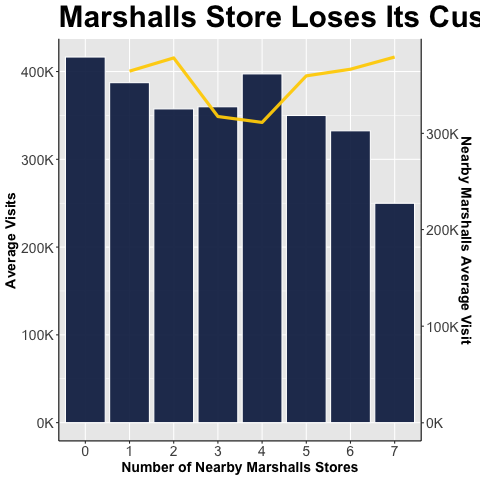

In [123]:
%%R -i final_data
library(ggplot2)
library(dplyr)
library(stringr)
library(scales)

comp_df <- final_data %>% select("Rank":"State","Total_Visits","num_nearby_Burlington":"tot_visits_nearby_Marshalls")
marshalls_can <- final_data %>% 
  select("Rank":"State","Total_Visits",ends_with("_Marshalls")) %>%
  filter(Name == "Marshalls") %>%
  group_by(num_nearby_Marshalls) %>%
  summarise(Avg_Visit = mean(Total_Visits), Avg_Visit_to_Nearby_Marshalls = sum(tot_visits_nearby_Marshalls)/sum(num_nearby_Marshalls))

sfactor <- max(marshalls_can$Avg_Visit, na.rm=TRUE)/max(marshalls_can$Avg_Visit_to_Nearby_Marshalls,na.rm=TRUE)

marshalls_can %>%
  ggplot() +
  geom_bar((aes(x=as.factor(num_nearby_Marshalls),y=Avg_Visit)),stat="identity",fill="#182C54",colour="white",alpha=0.95)+
  geom_line(aes(x=as.factor(num_nearby_Marshalls),y=Avg_Visit_to_Nearby_Marshalls*sfactor),stat="identity",group = 1, color = "#FFD100",size=1.5,,alpha=0.95)+
  scale_y_continuous(labels = label_number(suffix = "K", scale = 1e-3),
                     "Average Visits", 
                     sec.axis = sec_axis(trans= ~./sfactor, 
                                         name = "Nearby Marshalls Average Visit",
                                         labels = label_number(suffix = "K", scale = 1e-3)))+
  xlab("Number of Nearby Marshalls Stores")+
  ggtitle("Marshalls Store Loses Its Customers To Its Nearby Stores")+
  theme(axis.text=element_text(size=14),
        axis.title=element_text(size=14,face="bold"),
        plot.title = element_text(size = 30, face = "bold"),
        axis.line = element_line(color = "black"),
        axis.line.y = element_line())

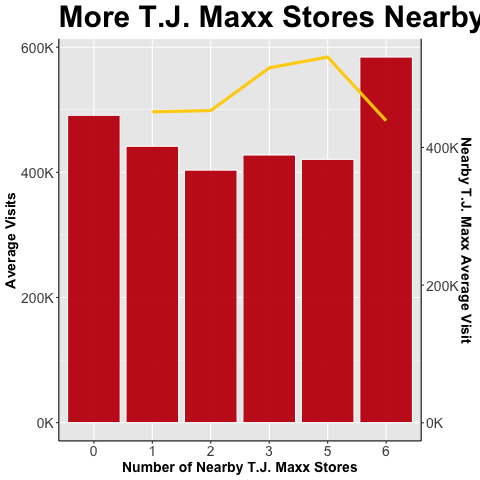

In [124]:
%%R -i final_data

TJ_can <- final_data %>% 
  select("Rank":"State","Total_Visits",ends_with("_T.J._Maxx")) %>%
  filter(Name == "T.J. Maxx") %>%
  group_by(num_nearby_T.J._Maxx) %>%
  summarise(Avg_Visit = mean(Total_Visits), Avg_Visit_to_Nearby_T.J._Maxx = sum(tot_visits_nearby_T.J._Maxx)/sum(num_nearby_T.J._Maxx))

sfactor2 <- max(TJ_can$Avg_Visit, na.rm=TRUE)/max(TJ_can$Avg_Visit_to_Nearby_T.J._Maxx,na.rm=TRUE)
TJ_can %>%
  ggplot() +
  geom_bar((aes(x=as.factor(num_nearby_T.J._Maxx),y=Avg_Visit)),stat="identity",fill="#C40D11",colour="white",alpha=0.95)+
  geom_line(aes(x=as.factor(num_nearby_T.J._Maxx),y=Avg_Visit_to_Nearby_T.J._Maxx*sfactor2),stat="identity",group = 1, color = "#FFD100",size=1.5,,alpha=0.95)+
  scale_y_continuous(labels = label_number(suffix = "K", scale = 1e-3),
                     "Average Visits", 
                     sec.axis = sec_axis(trans= ~./sfactor, 
                                         name = "Nearby T.J. Maxx Average Visit",
                                         labels = label_number(suffix = "K", scale = 1e-3)))+
  xlab("Number of Nearby T.J. Maxx Stores")+
  ggtitle("More T.J. Maxx Stores Nearby Increases The Average Visit")+
  theme(axis.text=element_text(size=14),
        axis.title=element_text(size=14,face="bold"),
        plot.title = element_text(size = 30, face = "bold"),
        axis.line = element_line(color = "black"),
        axis.line.y = element_line())

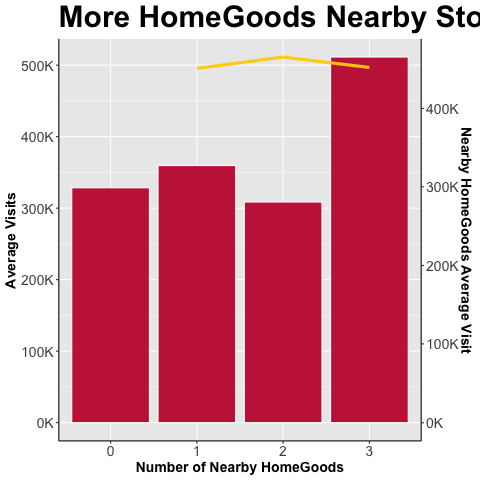

In [125]:
%%R -i final_data
HG_can <- final_data %>% 
  select("Rank":"State","Total_Visits",ends_with("_HomeGoods")) %>%
  filter(Name == "HomeGoods") %>%
  group_by(num_nearby_HomeGoods) %>%
  summarise(Avg_Visit = mean(Total_Visits), Avg_Visit_to_Nearby_HomeGoods = sum(tot_visits_nearby_HomeGoods)/sum(num_nearby_HomeGoods))

sfactor3 <- max(HG_can$Avg_Visit, na.rm=TRUE)/max(HG_can$Avg_Visit_to_Nearby_HomeGoods,na.rm=TRUE)
HG_can %>%
  ggplot() +
  geom_bar((aes(x=as.factor(num_nearby_HomeGoods),y=Avg_Visit)),stat="identity",fill="#C51F3E",colour="white",alpha=0.95)+
  geom_line(aes(x=as.factor(num_nearby_HomeGoods),y=Avg_Visit_to_Nearby_HomeGoods*sfactor3),stat="identity",group = 1, color = "#FFD100",size=1.5,,alpha=0.95)+
  scale_y_continuous(labels = label_number(suffix = "K", scale = 1e-3),
                     "Average Visits", 
                     sec.axis = sec_axis(trans= ~./sfactor, 
                                         name = "Nearby HomeGoods Average Visit",
                                         labels = label_number(suffix = "K", scale = 1e-3)))+
  xlab("Number of Nearby HomeGoods")+
  ggtitle("More HomeGoods Nearby Stores Boost More Visits")+
  theme(axis.text=element_text(size=14),
        axis.title=element_text(size=14,face="bold"),
        plot.title = element_text(size = 30, face = "bold"),
        axis.line = element_line(color = "black"),
        axis.line.y = element_line())

In [185]:
%%R -i final_data
wd = getwd()
paste(wd,"/Data/Final_Data/starbucks.csv",sep="")
starbucksdf <- read.csv(paste(wd,"/Data/Final_Data/starbucks.csv",sep=""))
  
starbucksdf %>%
  select(Name, Total_Visits,num_starbucks) %>%
  group_by(num_starbucks,Name) %>%
  summarise(avg_visit = mean(Total_Visits)) %>%
  ggplot(aes(x=as.factor(num_starbucks),y=avg_visit, fill=Name)) +
  geom_col(position = "dodge", color = "black") +
  scale_fill_manual(values = c("HomeGoods" = "Green",
                               "T.J. Maxx" = "#C40D11",
                               "Marshalls" = "#182C54"))+
  xlab("Number of Nearby Starbucks")+
  ylab("Average Visit")+
  ggtitle("Nearby Starbucks Increase Visits To TJX Stores")+
  theme(axis.text=element_text(size=14),
        axis.title=element_text(size=14,face="bold"),
        plot.title = element_text(size = 30, face = "bold"),
        axis.line = element_line(color = "black"),
        axis.line.y = element_line())

UsageError: Cell magic `%%R` not found.
